# **Project: MRFO-base feature selection algorithm for improved LSTM performance in energy demand forecasting**

# FEATURE ENGINEERING AND SELECTION

## DATA LOADING

In [108]:
import datetime
import json
import os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import wilcoxon


import random
import numpy as np
import torch

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
current_directory = os.getcwd()
filename = 'energy_dataset.pkl'
file_path = os.path.join(current_directory, filename)

In [110]:
with open(file_path, 'rb') as i:
    df = pickle.load(i)

# Extract relevant columns
cols = ['nd']
df = df[cols]

## FEATURISATION METHODS

###  FUNCTIONS AND CLASSES

In [111]:
#Creating a Custom Dataset for the DataLoader object

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target, seq_length):
        self.data = data
        self.target = target
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.target[index + self.seq_length - 1]
        return x, y

In [112]:
def create_lagged_features_with_filters(df, all_lags,  hourly_lags=False,  daily_lags=False, yearly_lags=False, custom_lag_ids=None):

    df = pd.DataFrame(df)

    lagged_df = pd.DataFrame()

    # Create hourly lags up to 1 day
    if hourly_lags:
        for i in range(1, 48+1):
            lagged_df[f'lag_{i}'] = df['nd'].shift(i)

    # Create daily lags up to 1 week
    if daily_lags:
        for i in daily_lags_list:
            lagged_df[f'lag_{i}'] = df['nd'].shift(i)

    # Create yearly lags up to 7 years
    if yearly_lags:
        for i in yearly_lags_list:
            lagged_df[f'lag_{i}'] = df['nd'].shift(i)

    # Create custom lags
    if custom_lag_ids is not None:
        for i in all_lags[custom_lag_ids]:
            lagged_df[f'lag_{i}'] = df['nd'].shift(i)

    lagged_df = lagged_df.loc[:, ~lagged_df.columns.duplicated()]

    result_df = pd.concat([lagged_df, df], axis=1)

    result_df.dropna(inplace=True)

    sorted_columns = sorted(result_df.columns, key=lambda x: int(x.split('_')[1]) if 'lag_' in x else float('inf'))
    result_df = result_df[sorted_columns]

    return result_df


In [113]:
def create_features_LSTM(data, seq_length, batch_size, batch_size_y = None):

    X = data.iloc[:, :-1]
    y = data['nd']

    X_values = X.values
    X_values = np.flip(X_values, axis=1) #Flipping the elements of the sequences to keep temporal order

    y_values = y.values.reshape(-1, 1)


    X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, shuffle = False)

    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    X_train_tensors = torch.from_numpy(X_train_scaled).float().to(device)
    y_train_tensors = torch.from_numpy(y_train_scaled).float().to(device)


    X_test_tensors = torch.from_numpy(X_test_scaled).float().to(device)
    y_test_tensors = torch.from_numpy(y_test_scaled).float().to(device)


    train_dataset = TimeSeriesDataset(X_train_tensors, y_train_tensors, seq_length)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, drop_last=True)

    test_dataset = TimeSeriesDataset(X_test_tensors, y_test_tensors, seq_length)

    if batch_size_y:
      test_loader = DataLoader(test_dataset, batch_size = batch_size_y, shuffle=False, drop_last=True)
    else:
      test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

    return train_loader, test_loader, scaler, X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors, y_train, y_test

In [114]:
class MLRModel(nn.Module):
    def __init__(self, input_size):
        super(MLRModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

### 1. AUTOCORRELATION PLOTS

In [115]:
# Calculating the autocorrelation function (ACF)

diff_train_data_close = df['nd'].diff().dropna()

lags = 264307  # Number of lags to calculate
acf_values, conf_intervals = acf(diff_train_data_close, nlags=lags, fft=True, alpha=0.05)

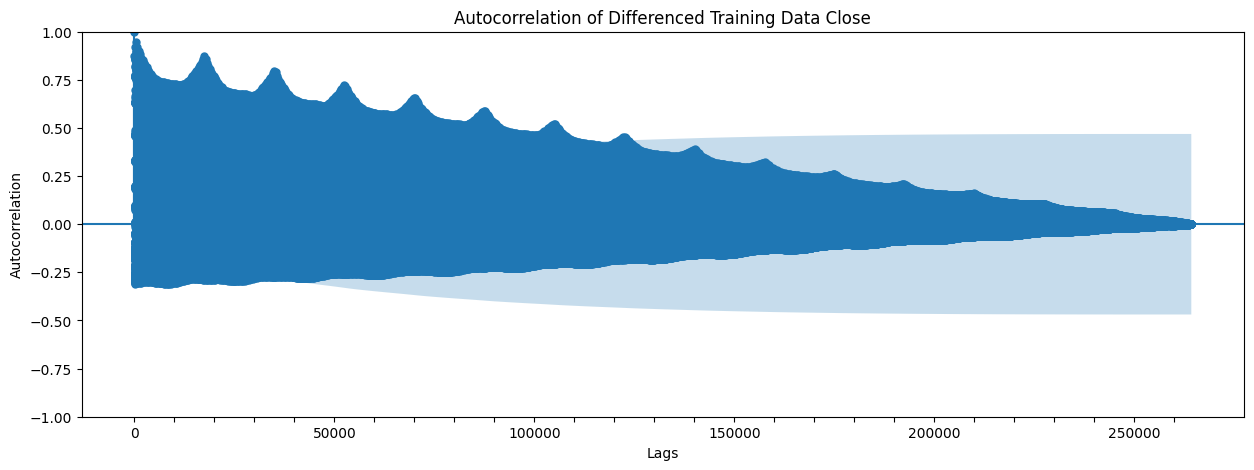

In [116]:
# Plotting the overall autocorrelation
plt.rcParams['figure.figsize'] = (15, 5)
fig, ax = plt.subplots()
plot_acf(diff_train_data_close, lags=264305, ax=ax)

xticks = range(0, 264308, 10000)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
xtick_labels = ['' if x % 50000 != 0 else str(x) for x in xticks]
ax.set_xticklabels(xtick_labels)

plt.title('Autocorrelation of Differenced Training Data Close')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


#### Yearly lags

The list below corresponds to the significant (i.e. above the confidence interval) peak lag values from the ACF plot above. It can be seen that first prominent peak value corresponds to 7 days before the last timestep (336), and the other significant ones correspond to each past year up to 7 years , same date, from the last time step.
This reinforces the significant weekly and yearly seasonality of our data.
Therefore, lags for a week prior and each of the 7 years prior will be used to help train our model best.

In [117]:
lag_1 = np.argmax(acf_values[1:10000]) + 1
lag_2 = np.argmax(acf_values[10000:30000]) + 10000
lag_3 = np.argmax(acf_values[30000:45000]) + 30000
lag_4 = np.argmax(acf_values[45000:60000]) + 45000
lag_5 = np.argmax(acf_values[60000:80000]) + 60000
lag_6 = np.argmax(acf_values[80000:100000]) + 80000
lag_7 = np.argmax(acf_values[100000:115000]) + 100000
lag_8 = np.argmax(acf_values[115000:130000]) + 115000

yearly_lags_list = [lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8]
yearly_lags_list

[17470, 34940, 52410, 69880, 87686, 105156, 122626]

#### Daily lags

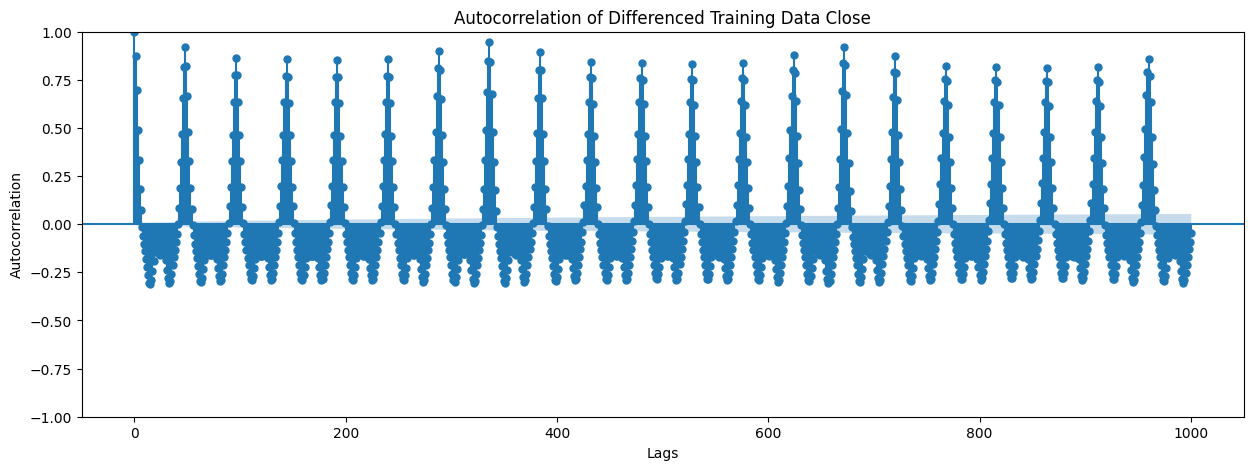

In [118]:
plt.rcParams['figure.figsize'] = (15, 5)

# Plot the daily autocorrelation
plot_acf(diff_train_data_close, lags=1000, use_vlines = True, )  # Adjust lags as needed
plt.title('Autocorrelation of Differenced Training Data Close')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


In [119]:
#Finding the peaks in the above plot
find_peaks(acf_values[0:1000], height = 0.75, distance = 20)

(array([ 48,  96, 144, 192, 240, 288, 336, 384, 432, 480, 528, 576, 624,
        672, 720, 768, 816, 864, 912, 960]),
 {'peak_heights': array([0.9181986 , 0.8659808 , 0.85656304, 0.85288532, 0.85611316,
         0.90112529, 0.94643948, 0.89371957, 0.84439832, 0.83498327,
         0.831606  , 0.8352543 , 0.87774279, 0.92172713, 0.87170415,
         0.8236965 , 0.81435943, 0.81166492, 0.81575919, 0.85734599])})

From plotting for only 1000 lags (about 3 weeks), we can see that the daily seasonality (multiples of 48) is also very significant and should be included.

In [120]:
peaks = find_peaks(acf_values[0:384], height = 0.75, distance = 20) #Only the previous 336 time steps (last week) will be added

In [121]:
daily_lags_list = peaks[0]

#### Hourly lags

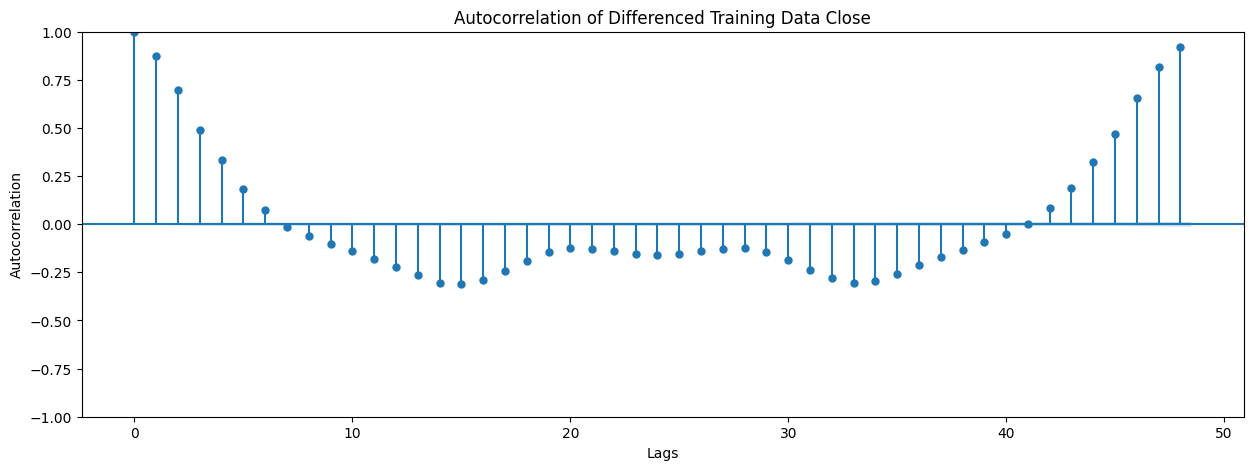

In [122]:
plt.rcParams['figure.figsize'] = (15, 5)

# Plot hourly the autocorrelation
plot_acf(diff_train_data_close, lags=48)  # Adjust lags as needed
plt.title('Autocorrelation of Differenced Training Data Close')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Now plotting for 50 lags (about 1 day), we can see that the intra-day seasonality doesnt bring much lag relevance except for the lag -1 and the lag -47 (the one just after the beginning of the day).


In [123]:
hourly_lags_list = list(range(1, 48+1))

In [124]:
all_lags = np.concatenate((hourly_lags_list, list(daily_lags_list), yearly_lags_list))
all_lags = np.unique(all_lags)

In [125]:
all_lags

array([     1,      2,      3,      4,      5,      6,      7,      8,
            9,     10,     11,     12,     13,     14,     15,     16,
           17,     18,     19,     20,     21,     22,     23,     24,
           25,     26,     27,     28,     29,     30,     31,     32,
           33,     34,     35,     36,     37,     38,     39,     40,
           41,     42,     43,     44,     45,     46,     47,     48,
           96,    144,    192,    240,    288,    336,  17470,  34940,
        52410,  69880,  87686, 105156, 122626])

### FEATURE PRE-PROCESSING FOR LSTM

In [126]:
#Only last 48 half-hourly lags (set A)
data_hourly = create_lagged_features_with_filters(
    df,
    all_lags,
    hourly_lags=True
)

#Set B
data_daily = create_lagged_features_with_filters(
    df,
    all_lags,
    daily_lags=True
)

#Set C
data_yearly = create_lagged_features_with_filters(
    df,
    all_lags,
    yearly_lags=True
)

#Set D
data_daily_yearly = create_lagged_features_with_filters(
    df,
    all_lags,
    daily_lags=True,
    yearly_lags=True
)

#Set E
data_all = create_lagged_features_with_filters(
    df,
    all_lags,
    daily_lags=True,
    hourly_lags=True,
    yearly_lags=True
)


data_configs = {
    "hourly": data_hourly,
    "daily": data_daily,
    "yearly": data_yearly,
    "daily_yearly": data_daily_yearly,
    "all": data_all
}

# MODEL TRAINING

## Functions and classes

In [127]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.25)
        self.fc = nn.Linear(hidden_size, output_size)

        # Apply Xavier/Glorot initialization
        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

        init.xavier_uniform_(self.fc.weight.data)
        self.fc.bias.data.fill_(0)

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        else:
            h0, c0 = hidden

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out, (hn, cn)

In [128]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, plot=False):
  epoch_losses = []

  for epoch in range(num_epochs):
      model.train()
      losses = []

      hidden = None  # Initialise hidden state at the start of each epoch

      for batch_x, batch_y in train_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)

          optimizer.zero_grad()

          # Carry over the hidden state from the previous batch
          outputs, hidden = model(batch_x, hidden)

          # Detach the hidden state to prevent backpropagation through previous batches
          if hidden is not None:
              hidden = tuple([h.detach() for h in hidden])

          loss = criterion(outputs, batch_y)
          loss.backward()

          optimizer.step()

          losses.append(float(loss))

      epoch_losses.append(np.mean(losses))

      print(f'Epoch {epoch + 1}/{num_epochs}. Loss: {epoch_losses[-1]:.5f}.')

  if plot:
      plt.plot(epoch_losses)  # Plots the average loss across batches for each epoch
      plt.xlabel('Epoch')
      plt.ylabel('Average MSE')
      plt.show()

  return model, epoch_losses



In [129]:
def get_train_predictions(model, train_loader, y_train, scaler, step_size=336):

    model.eval()

    train_predictions = []
    hidden = None

    with torch.no_grad():
        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device)
            preds, hidden = model(batch_x, hidden)

            hidden = tuple([h.detach() for h in hidden])

            train_predictions.append(preds.cpu().numpy())

    train_predictions = np.concatenate(train_predictions, axis=0)
    train_predictions_inverse = scaler.inverse_transform(train_predictions)

    # Calculate MAE and RMSE for each sequence of 336 steps
    num_steps = len(train_predictions_inverse)
    mae_list = []
    rmse_list = []

    for i in range(0, num_steps, step_size):
        end_idx = min(i + step_size, num_steps)
        actual_segment = y_train[i:end_idx]
        pred_segment = train_predictions_inverse[i:end_idx]

        mae_segment = mean_absolute_error(actual_segment, pred_segment)
        rmse_segment = np.sqrt(mean_squared_error(actual_segment, pred_segment))

        mae_list.append(mae_segment)
        rmse_list.append(rmse_segment)

    # Calculate the mean MAE and RMSE over all sequences
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    print(f'Mean Training MAE over all sequences: {mae_mean}')
    print(f'Mean Training RMSE over all sequences: {rmse_mean}')

    plt.plot(mae_list, label='MAE')
    plt.plot(rmse_list, label='RMSE')
    plt.title('MAE and RMSE over all sequences')
    plt.xlabel('Sequence')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


    # Plot actual vs predicted values for the overall training data
    plt.figure(figsize=(14, 7))
    plt.plot(y_train[:, 0], label='Actual ND')
    plt.plot(train_predictions_inverse[:, 0], label='Predicted ND')
    plt.title('Actual vs Predicted Electricity Demand (ND) on Training Data')
    plt.xlabel('Time steps (half hours)')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.show()

    # Plot actual vs predicted values (first and last week of the training data)
    print(f'Mean Training MAE and RMSE over first week: {mae_list[0]}, {rmse_list[0]}')

    fig, axs = plt.subplots(2, 1, figsize=(14, 7))

    axs[0].plot(y_train[0:336, 0], label='Actual ND')
    axs[0].plot(train_predictions_inverse[0:336, 0], label='Predicted ND')
    axs[0].set_title('Actual vs Predicted Electricity Demand (ND) on Training Data - First week')
    axs[0].set_xlabel('Time steps (half hours)')
    axs[0].set_ylabel('Demand (MW)')
    axs[0].legend()

    print(f'Mean Training MAE and RMSE over last week: {mae_list[-1]}, {rmse_list[-1]}')
    axs[1].plot(y_train[len(train_predictions_inverse)-336:len(train_predictions_inverse), 0], label='Actual ND')
    axs[1].plot(train_predictions_inverse[len(train_predictions_inverse)-336:len(train_predictions_inverse), 0], label='Predicted ND')
    axs[1].set_title('Actual vs Predicted Electricity Demand (ND) on Training Data - Last week')
    axs[1].set_xlabel('Time steps (half hours)')
    axs[1].set_ylabel('Demand (MW)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return train_predictions_inverse, mae_mean, rmse_mean, mae_list[0], rmse_list[0], mae_list[-1], rmse_list[-1]

In [130]:
def predict_n_steps(model, test_loader, y_test, scaler, n_steps):
    model.eval()
    predictions = []

    with torch.no_grad():
        hidden = None

        total_steps = 0

        for i, (batch_x, _) in enumerate(test_loader):
            if total_steps >= n_steps:
                break  # Stop if we have predicted n steps

            current_data = batch_x

            # Predict the next time step
            next_pred, hidden = model(current_data, hidden)

            hidden = tuple([h.detach() for h in hidden])

            predictions.append(next_pred.squeeze().cpu().detach().numpy())

            total_steps += 1  # Increment the step counter

        test_predictions = np.array(predictions)
        test_predictions = torch.from_numpy(test_predictions).float()
        predictions_inverse = scaler.inverse_transform(test_predictions.unsqueeze(0))

        mae = mean_absolute_error(y_test[:n_steps], predictions_inverse[0])
        rmse = np.sqrt(mean_squared_error(y_test[:n_steps], predictions_inverse[0]))


    print(f'Mean Absolute Error: {mae}, Root Mean Squared Error: {rmse}')

    # Plot actual vs predicted values for the training data
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[:n_steps, :], label='Actual ND')
    plt.plot(predictions_inverse[0], label='Predicted ND')
    plt.title('Actual vs Predicted Electricity Demand (ND)')
    plt.xlabel('Time steps (half hours)')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.show()

    return predictions_inverse, mae, rmse

In [131]:
# MRFO process functions

def manta_ray_foraging_optimization(data, criterion, num_iterations=10, num_manta_rays=10):
    data = data.iloc[:int(0.8*len(data)), :]  # Leaving out the test dataset

    # Initialise the manta rays population  (binary vectors representing feature subsets)
    manta_rays = np.random.randint(2, size=(num_manta_rays, num_features))

    for _ in range(num_iterations):
        fitness_scores = []

        for manta_ray in manta_rays:
            fitness = fitness_function(manta_ray, data, criterion)
            fitness_scores.append(fitness)

        # Select the best manta rays
        best_indices = np.argsort(fitness_scores)
        best_rays = [manta_rays[i] for i in best_indices[:num_manta_rays // 2]]

        # Update manta rays
        manta_rays = np.array(best_rays + [mutate(np.copy(best_rays[np.random.randint(len(best_rays))])) for _ in range(num_manta_rays // 2)])

    # Best manta ray
    best_manta_ray = manta_rays[np.argmax(fitness_scores)]
    return best_manta_ray

def mutate(ray):
    mutation = np.random.randint(0, 2, size=ray.shape)
    return ray ^ mutation


# MRFO fitness function

def fitness_function(features, data, criterion):
    """
    Evaluate the performance of a model with a given subset of features.
    """
    selected_features = np.where(features == 1)[0]
    selected_features = data.iloc[:, selected_features]
    data_selected = pd.concat([selected_features, data['nd']], axis=1)

    #Split further into train and test (validation) set
    train_loader, test_loader, scaler, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, y_train, y_test = create_features_LSTM(data_selected, seq_length, batch_size)

    model = LSTM(X_train_tensor.shape[1], hidden_size, num_layers, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epoch_losses = []
    model, epoch_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10, plot=False)

    # Evaluate the model on the test data
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(test_loader):
            next_pred, _ = model(batch_x)
            predictions.append(next_pred.squeeze().cpu().detach().numpy())

        test_predictions = np.array(predictions)
        test_predictions = torch.from_numpy(test_predictions).float()

        predictions_inverse = scaler.inverse_transform(test_predictions.unsqueeze(1))

        test_loss = mean_squared_error(y_test[:len(predictions_inverse)], predictions_inverse)

        # As MSE is chosen, higher fitness means lower loss
        return -test_loss.item()


In [132]:
def save_to_pickle(filename, object):
    with open(filename, 'wb') as file:
        pickle.dump(object, file)

def load_from_pickle(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [133]:
def save_model_complete(model, filename, optimizer=None, epoch=None):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'epoch': epoch
    }
    torch.save(checkpoint, filename)


def load_model_complete(filename):
    checkpoint = torch.load(filename)
    model = LSTM(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer = torch.optim.Adam(model.parameters())
    if checkpoint['optimizer_state_dict']:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    model.eval()

    return model, optimizer

## Training

In [134]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### CLASSIC LSTM

In [135]:
# Hyperparameters
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 10
learning_rate = 0.001
batch_size = 336
seq_length = 48
# criterion = nn.SmoothL1Loss(beta=1.0)
criterion = nn.MSELoss()

Epoch 1/10. Loss: 0.00500.
Epoch 2/10. Loss: 0.00084.
Epoch 3/10. Loss: 0.00057.
Epoch 4/10. Loss: 0.00044.
Epoch 5/10. Loss: 0.00035.
Epoch 6/10. Loss: 0.00030.
Epoch 7/10. Loss: 0.00027.
Epoch 8/10. Loss: 0.00023.
Epoch 9/10. Loss: 0.00021.
Epoch 10/10. Loss: 0.00020.


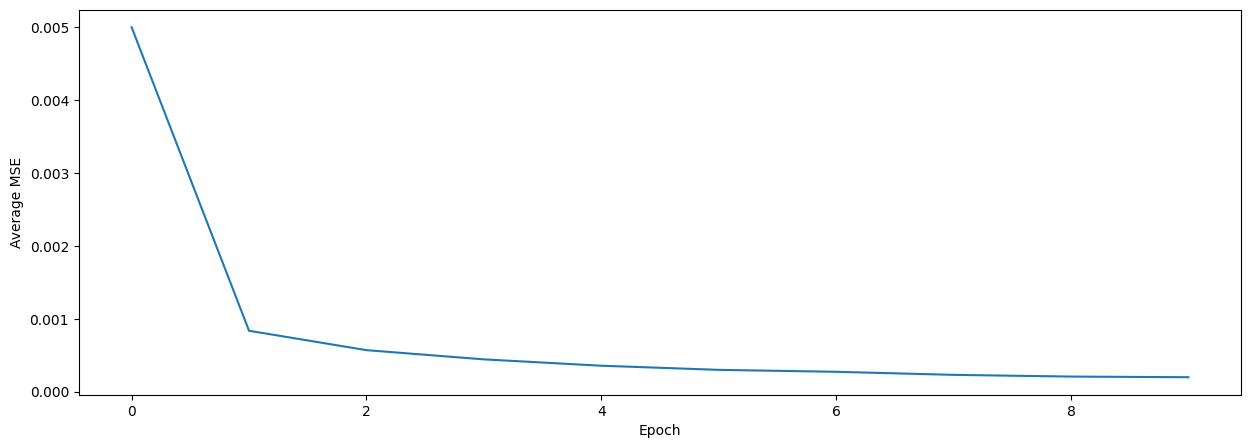

Epoch 1/10. Loss: 0.00734.
Epoch 2/10. Loss: 0.00289.
Epoch 3/10. Loss: 0.00260.
Epoch 4/10. Loss: 0.00246.
Epoch 5/10. Loss: 0.00239.
Epoch 6/10. Loss: 0.00234.
Epoch 7/10. Loss: 0.00231.
Epoch 8/10. Loss: 0.00230.
Epoch 9/10. Loss: 0.00225.
Epoch 10/10. Loss: 0.00225.


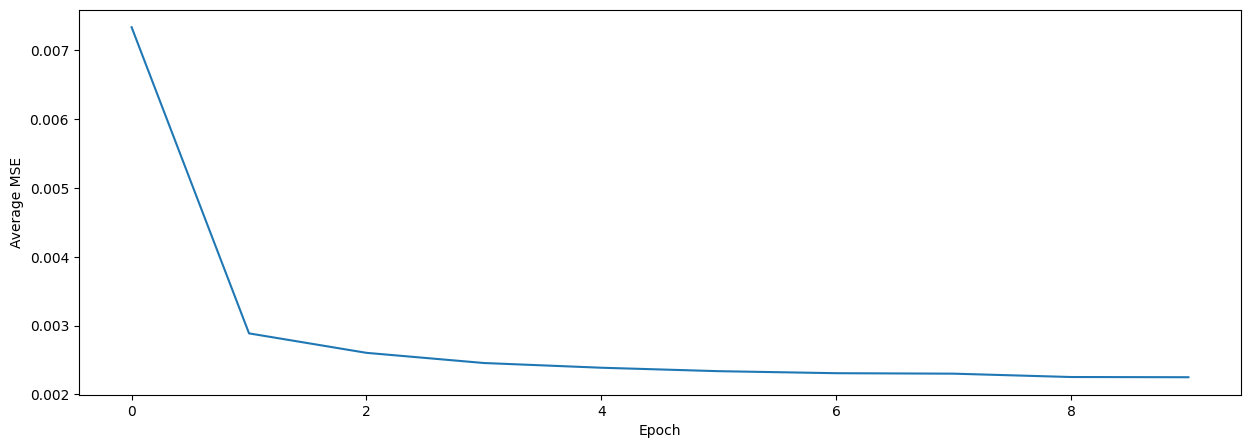

Epoch 1/10. Loss: 0.01417.
Epoch 2/10. Loss: 0.00548.
Epoch 3/10. Loss: 0.00499.
Epoch 4/10. Loss: 0.00474.
Epoch 5/10. Loss: 0.00462.
Epoch 6/10. Loss: 0.00461.
Epoch 7/10. Loss: 0.00457.
Epoch 8/10. Loss: 0.00446.
Epoch 9/10. Loss: 0.00454.
Epoch 10/10. Loss: 0.00466.


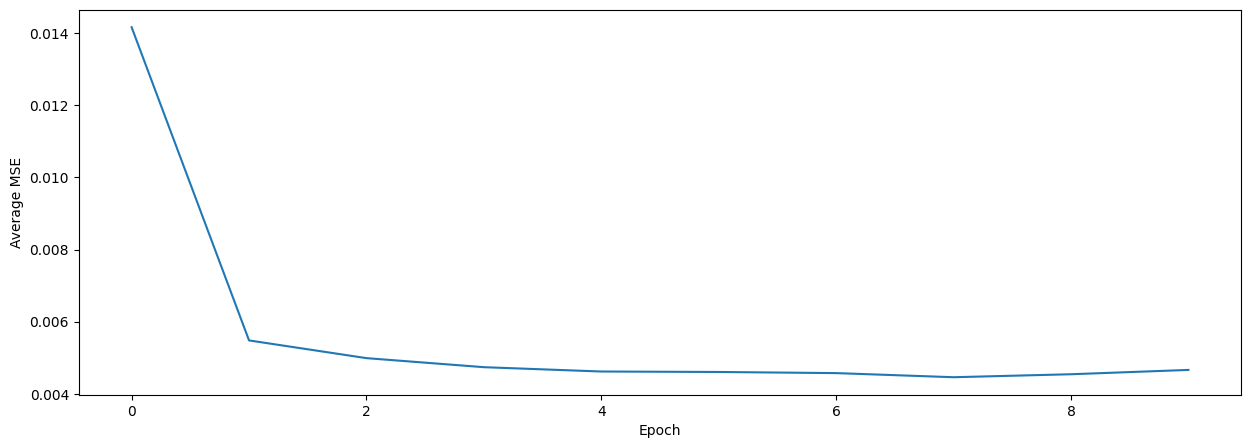

Epoch 1/10. Loss: 0.01130.
Epoch 2/10. Loss: 0.00475.
Epoch 3/10. Loss: 0.00415.
Epoch 4/10. Loss: 0.00384.
Epoch 5/10. Loss: 0.00361.
Epoch 6/10. Loss: 0.00348.
Epoch 7/10. Loss: 0.00336.
Epoch 8/10. Loss: 0.00327.
Epoch 9/10. Loss: 0.00317.
Epoch 10/10. Loss: 0.00313.


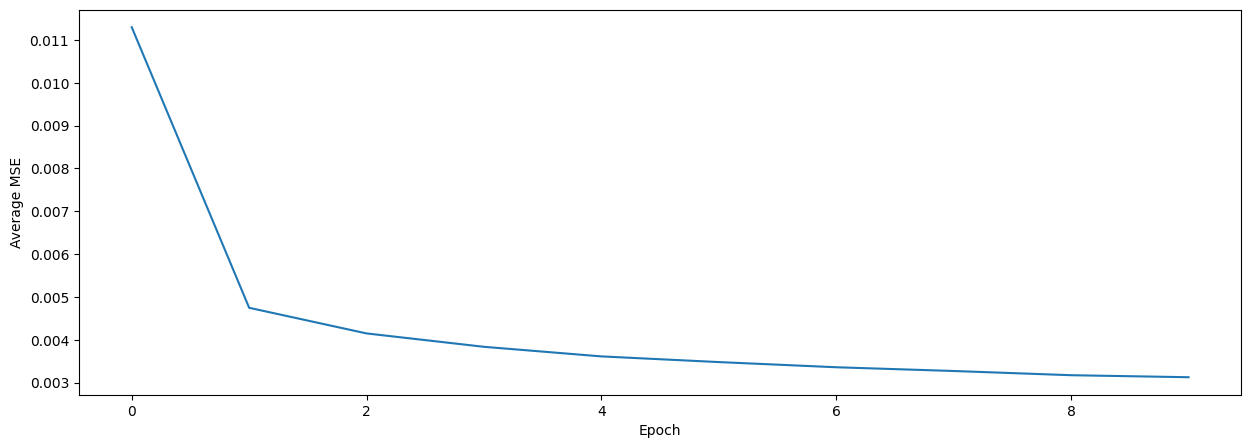

Epoch 1/10. Loss: 0.00715.
Epoch 2/10. Loss: 0.00198.
Epoch 3/10. Loss: 0.00130.
Epoch 4/10. Loss: 0.00109.
Epoch 5/10. Loss: 0.00092.
Epoch 6/10. Loss: 0.00078.
Epoch 7/10. Loss: 0.00068.
Epoch 8/10. Loss: 0.00060.
Epoch 9/10. Loss: 0.00052.
Epoch 10/10. Loss: 0.00047.


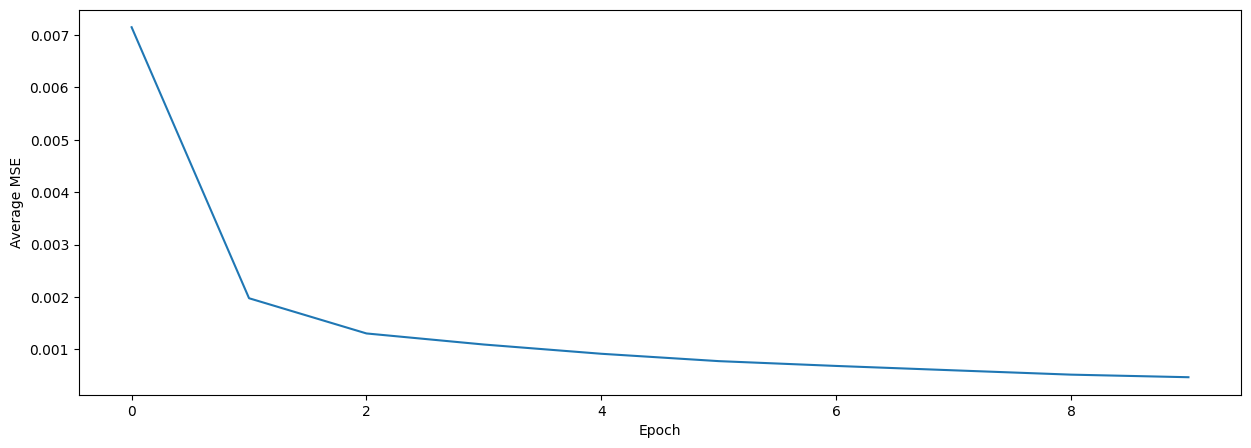

In [136]:
results = {}

for config_name, data in data_configs.items():

    train_loader, test_loader, scaler, X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors, y_train, y_test = create_features_LSTM(
        data, seq_length, batch_size)

    model = LSTM(X_train_tensors.shape[1], hidden_size, num_layers, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    trained_model, loss = train_model(model, train_loader, criterion, optimizer, num_epochs, plot =True)

    results[config_name] = {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "scaler": scaler,
        "X_train_tensors": X_train_tensors,
        "y_train_tensors": y_train_tensors,
        "X_test_tensors": X_test_tensors,
        "y_test_tensors": y_test_tensors,
        "y_train": y_train,
        "y_test": y_test,
        "loss": loss,
        "trained_model": trained_model
    }

Training predictions for hourly
Mean Training MAE over all sequences: 2269.7973379642976
Mean Training RMSE over all sequences: 3116.200903102866


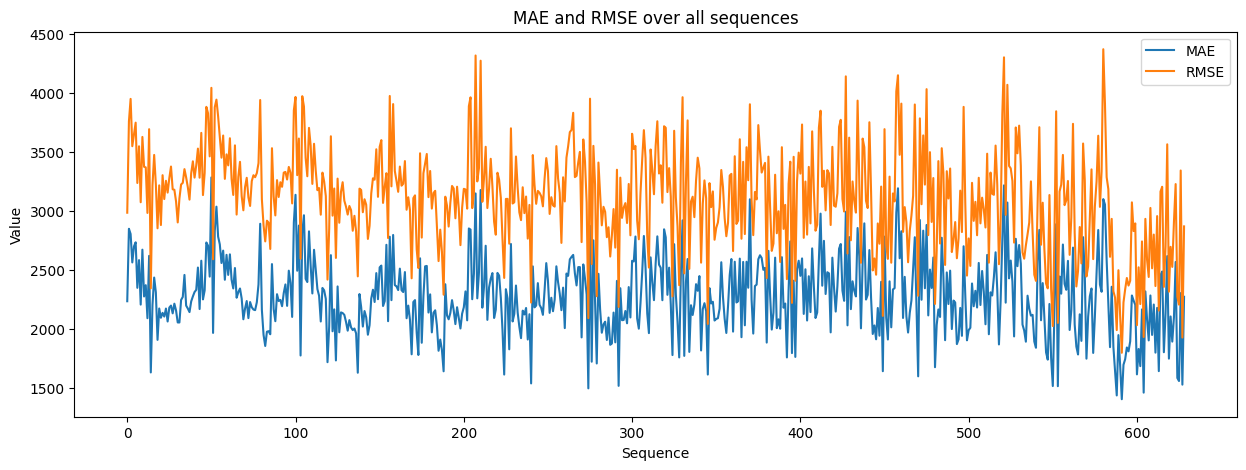

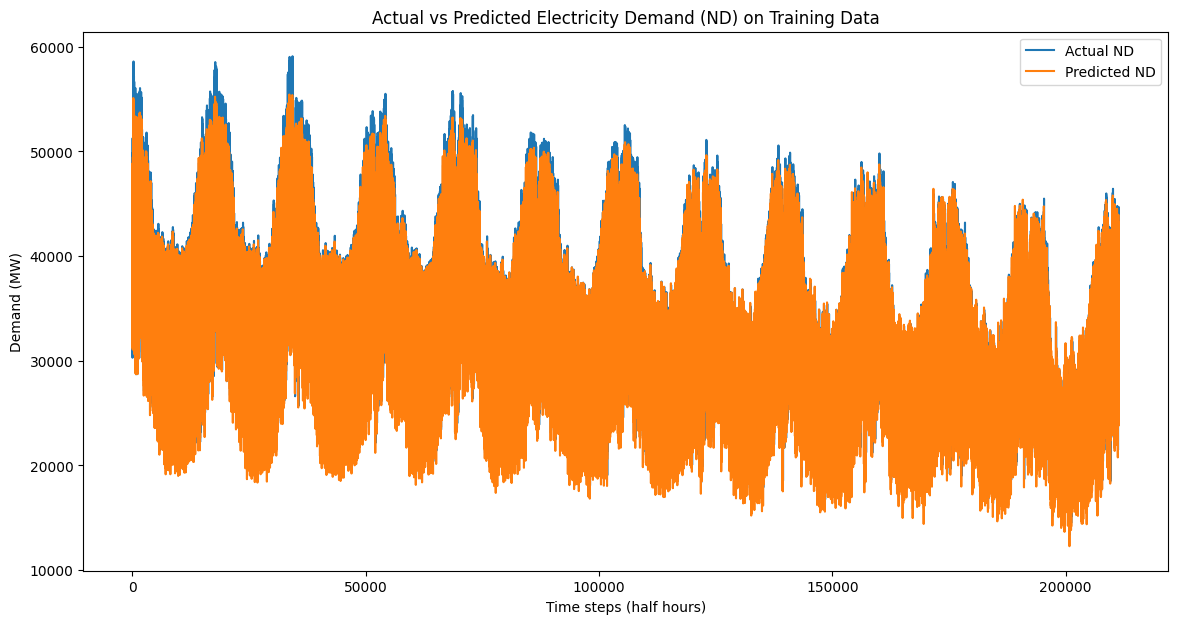

Mean Training MAE and RMSE over first week: 2236.169009254092, 2985.992462928011
Mean Training MAE and RMSE over last week: 2273.975830078125, 2870.10562907951


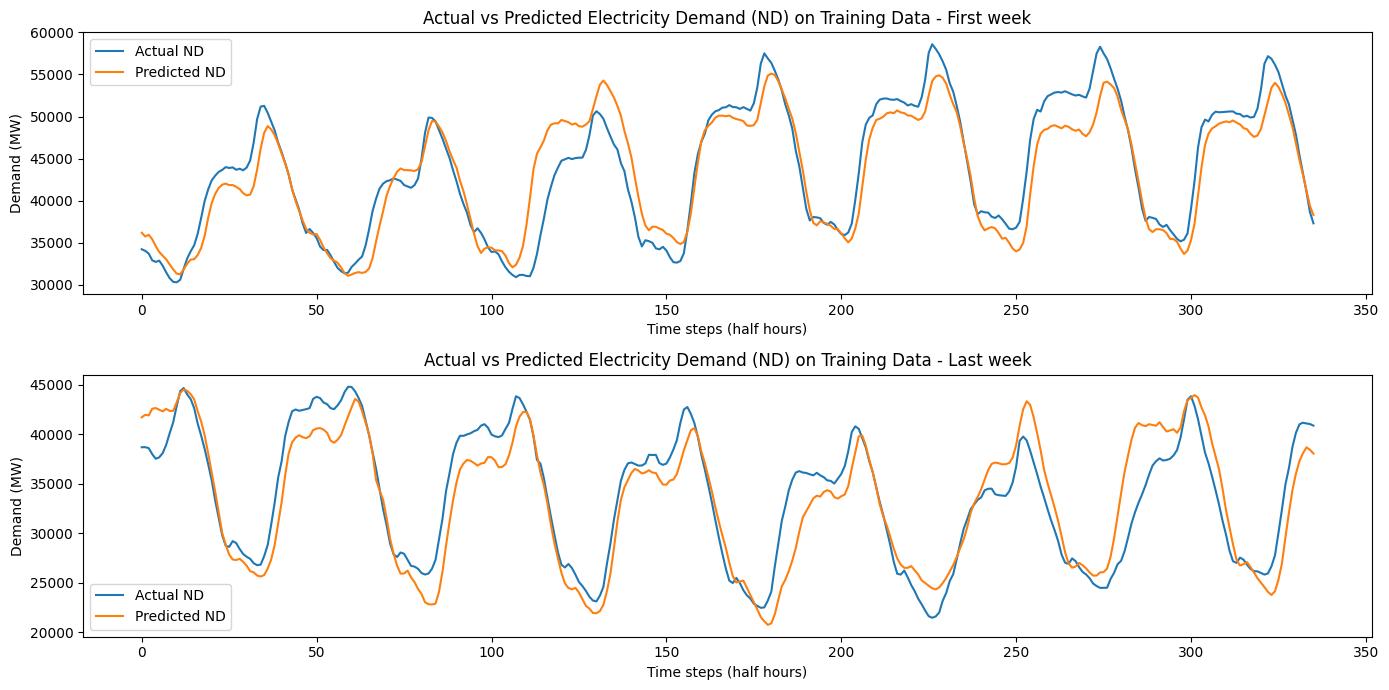

Training predictions for daily
Mean Training MAE over all sequences: 1861.5423193189063
Mean Training RMSE over all sequences: 2408.5679987246936


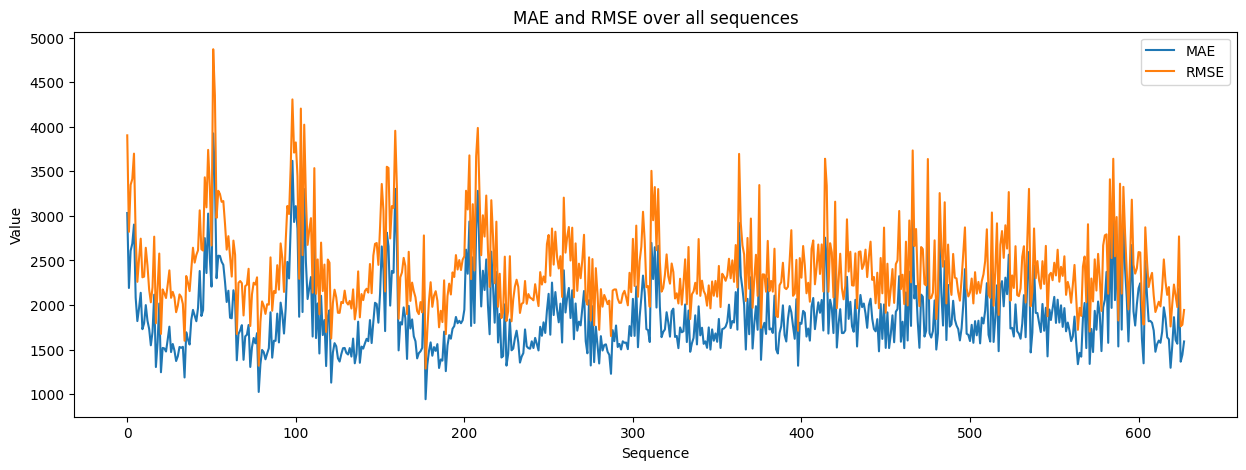

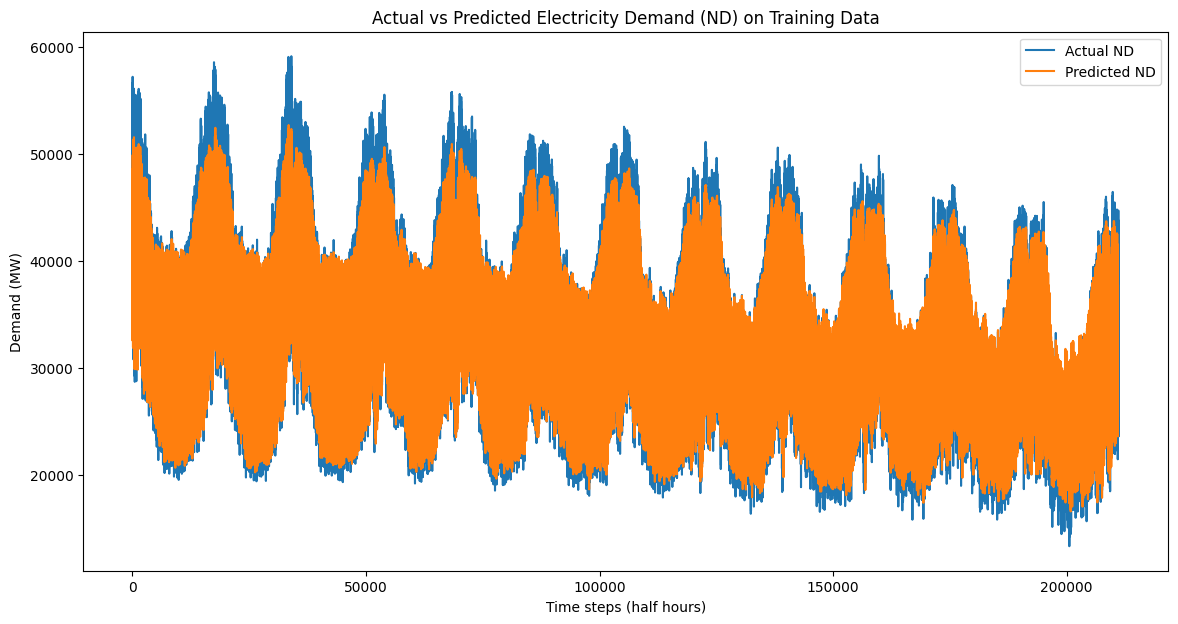

Mean Training MAE and RMSE over first week: 3032.2784540085568, 3904.3218450120107
Mean Training MAE and RMSE over last week: 1590.3641183035713, 1943.869632835885


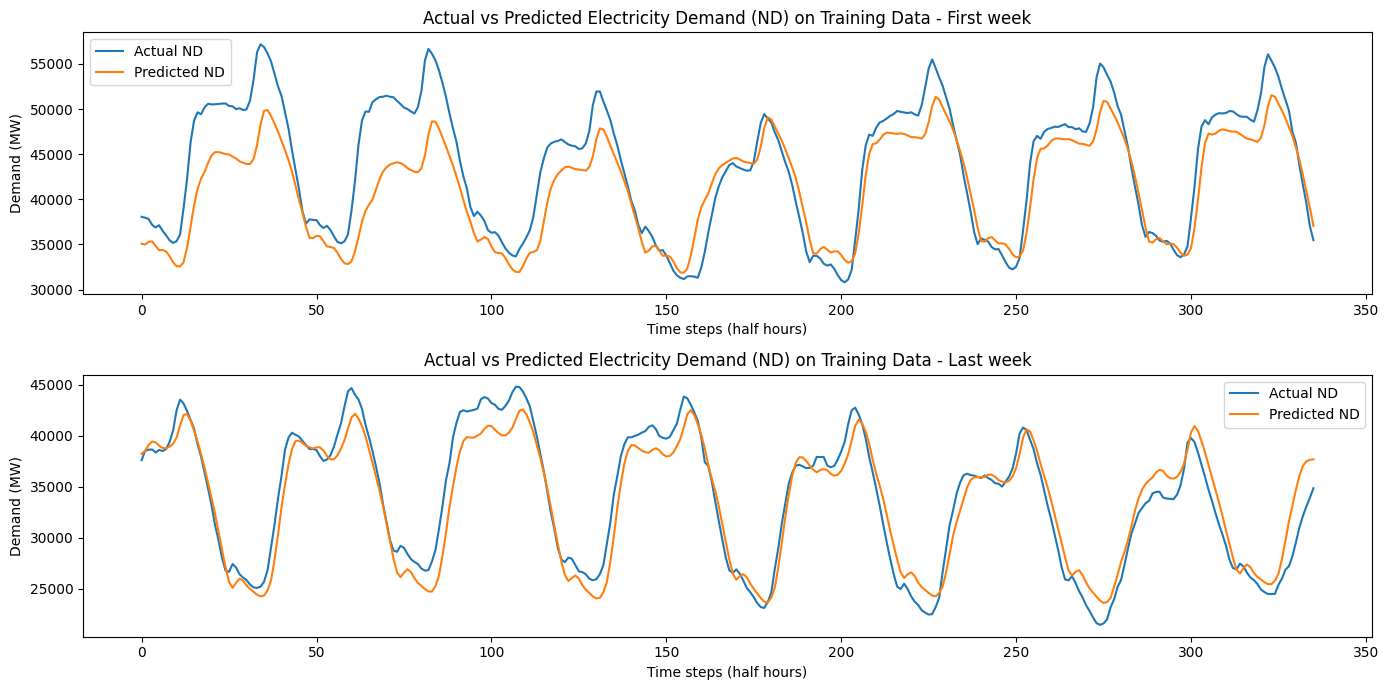

Training predictions for yearly
Mean Training MAE over all sequences: 2849.820838901271
Mean Training RMSE over all sequences: 3558.9559517401326


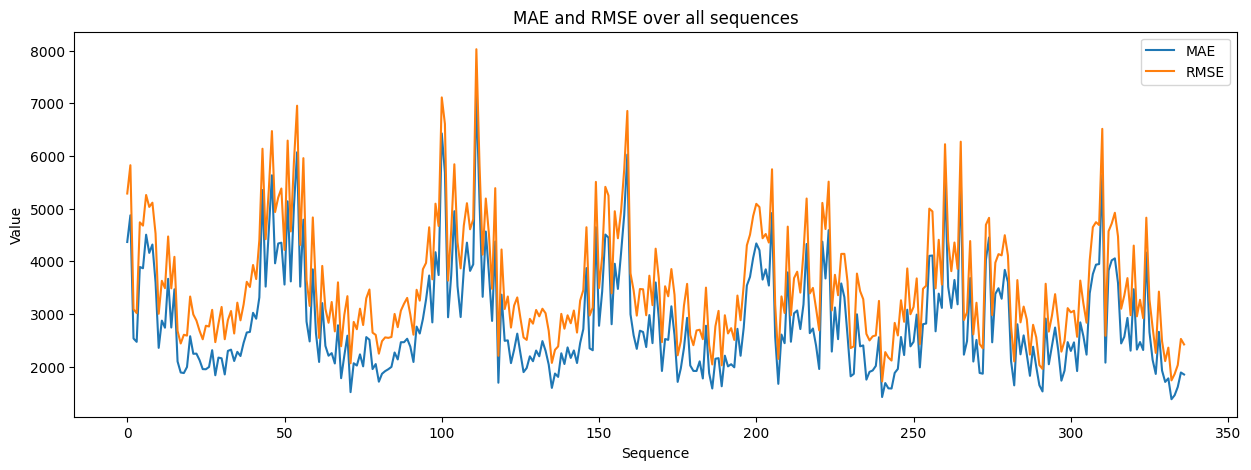

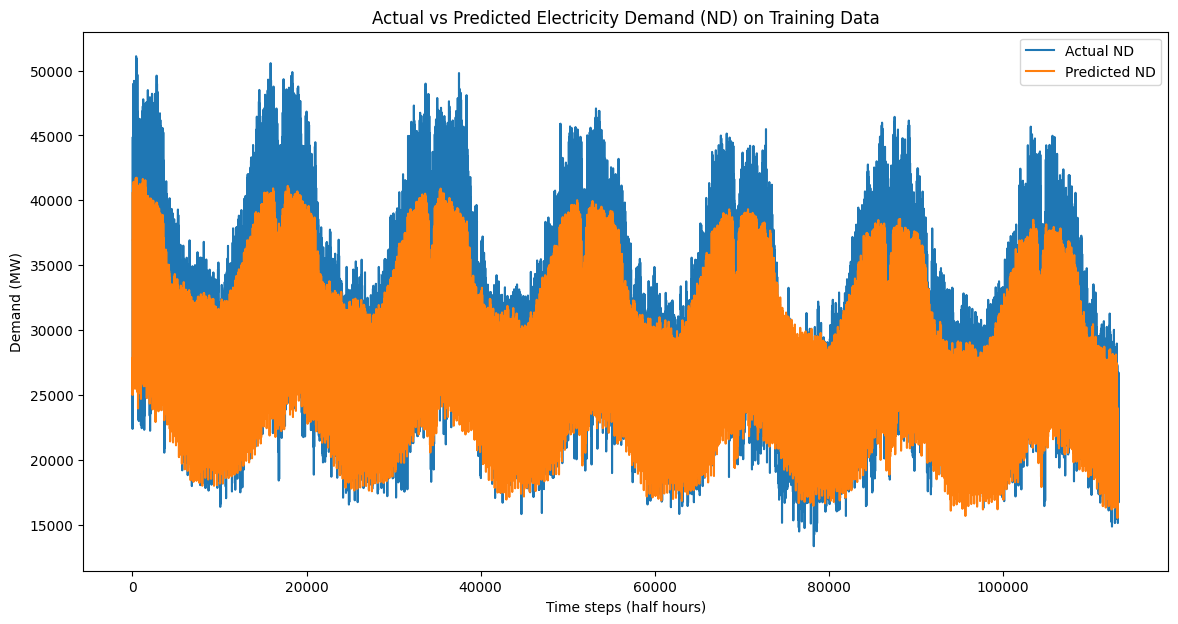

Mean Training MAE and RMSE over first week: 4367.460338774182, 5287.139146436764
Mean Training MAE and RMSE over last week: 1852.8631359281994, 2423.201288426785


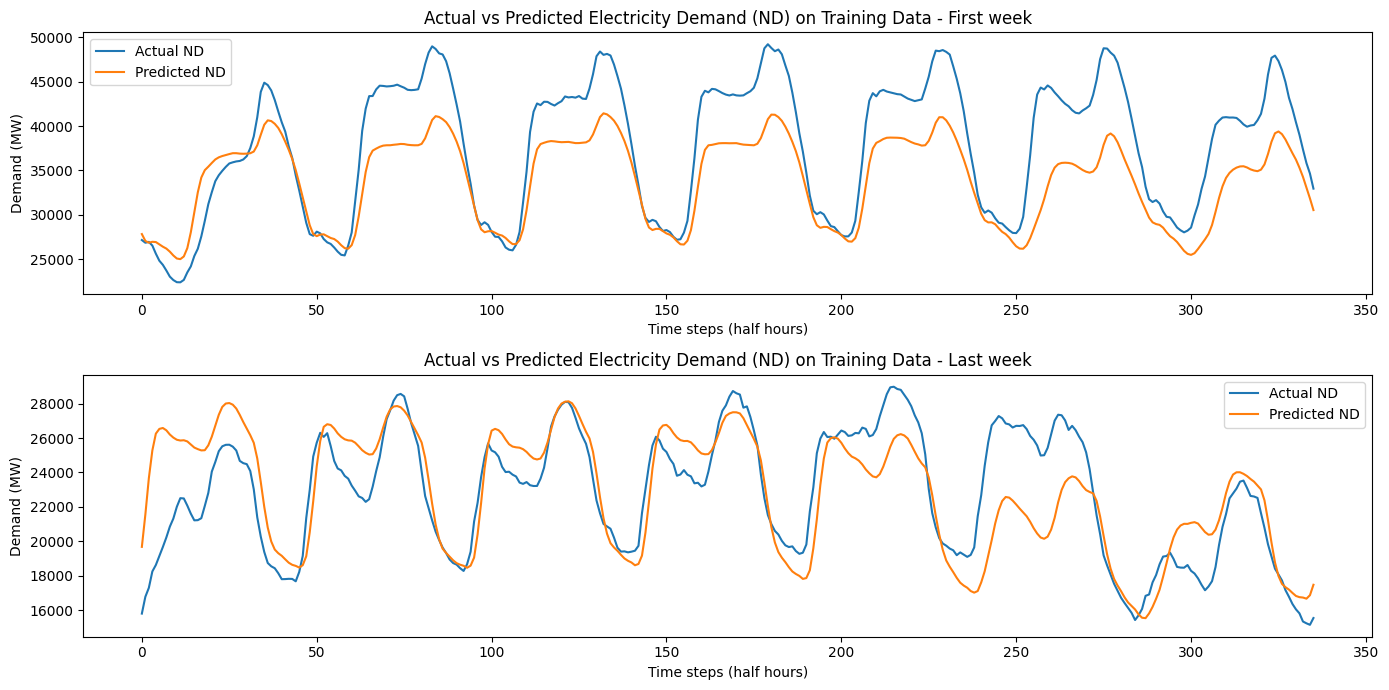

Training predictions for daily_yearly
Mean Training MAE over all sequences: 1957.1114429852812
Mean Training RMSE over all sequences: 2531.447913227442


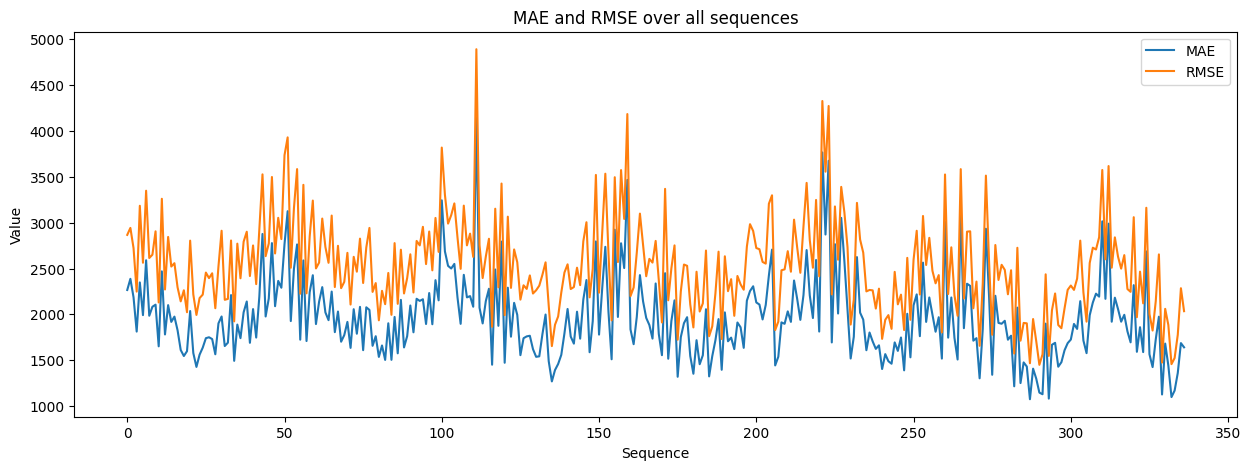

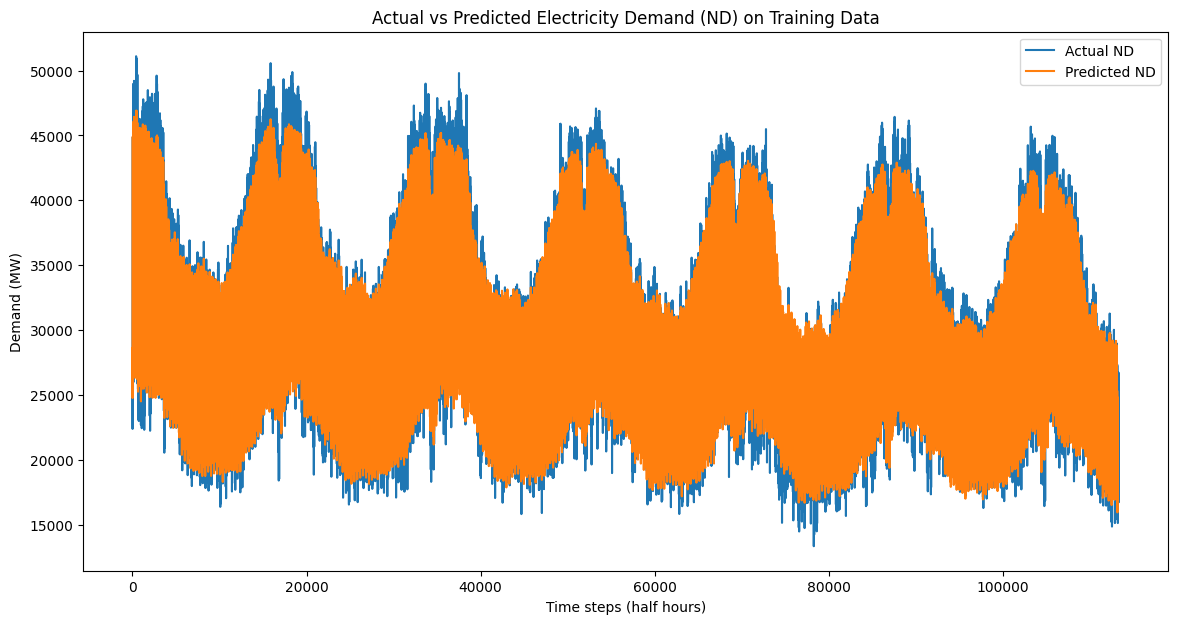

Mean Training MAE and RMSE over first week: 2265.7171921502977, 2866.9665465723524
Mean Training MAE and RMSE over last week: 1640.1945219494048, 2034.61774629577


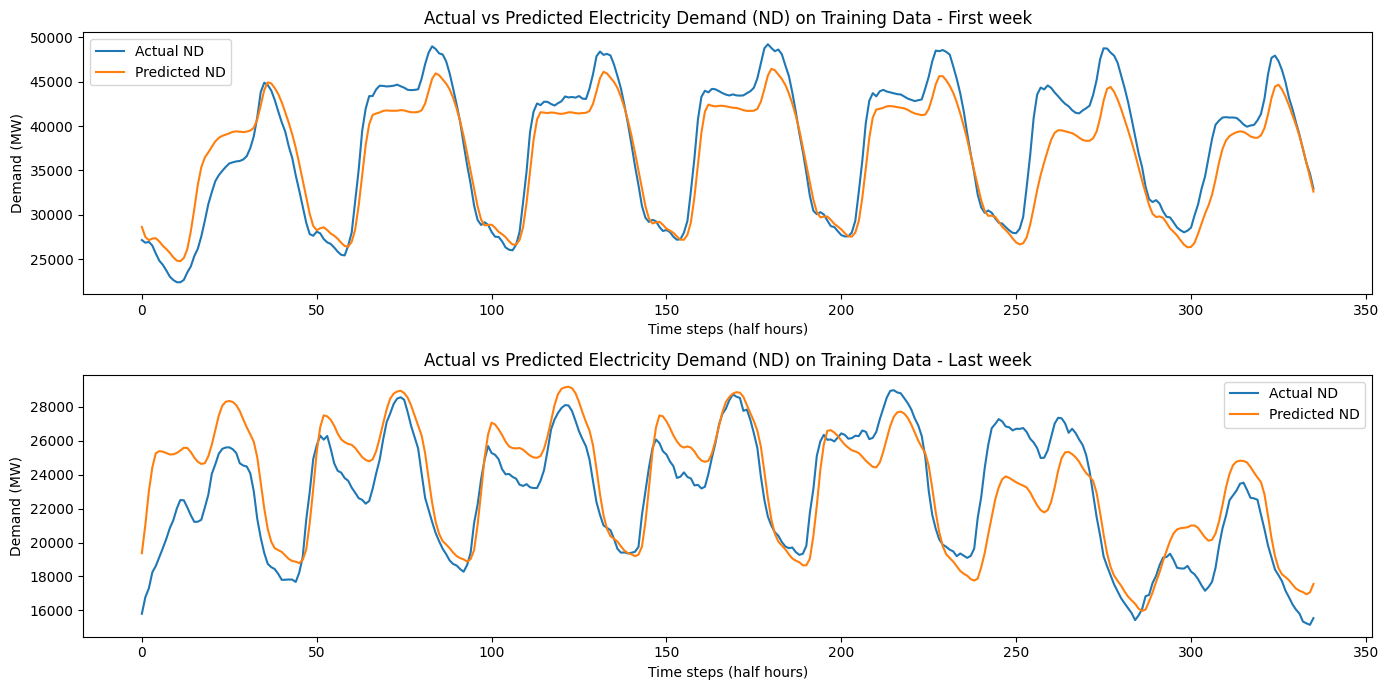

Training predictions for all
Mean Training MAE over all sequences: 2309.698007430265
Mean Training RMSE over all sequences: 3022.3305580541796


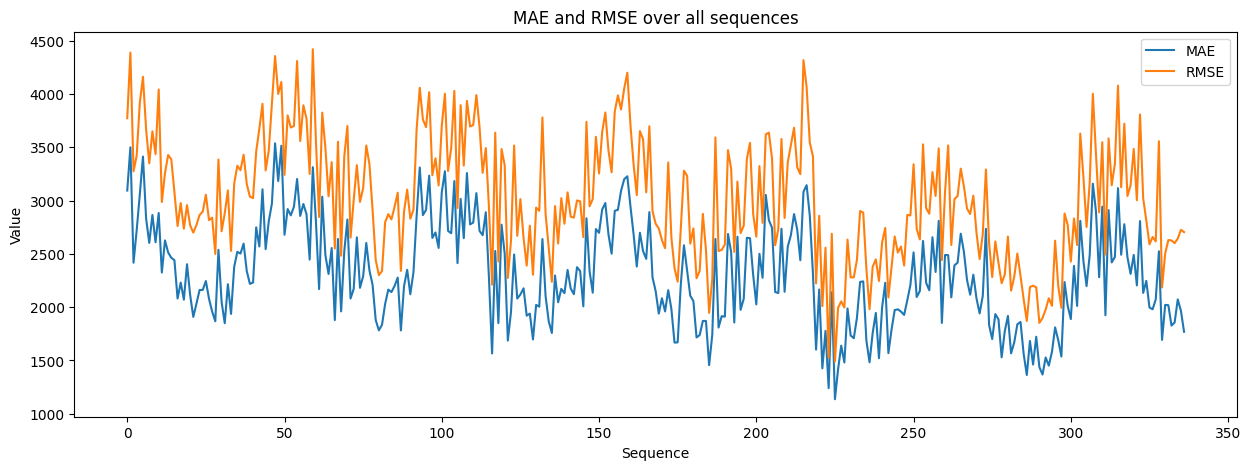

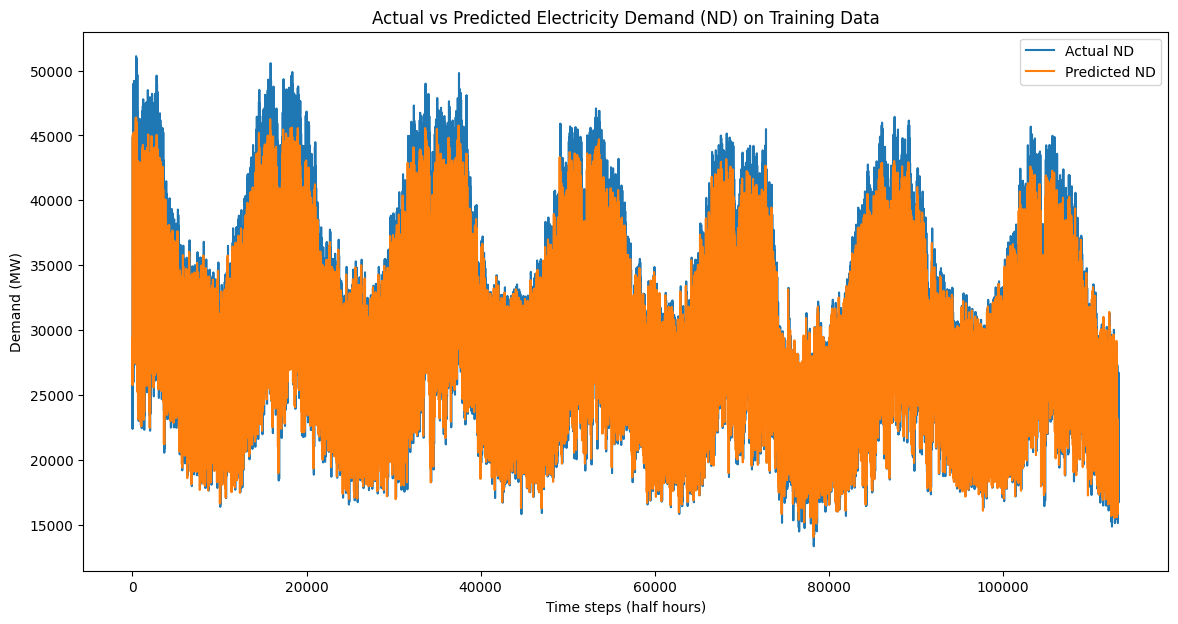

Mean Training MAE and RMSE over first week: 3094.4077962239585, 3773.4758337261355
Mean Training MAE and RMSE over last week: 1768.6059512183779, 2704.1959654307416


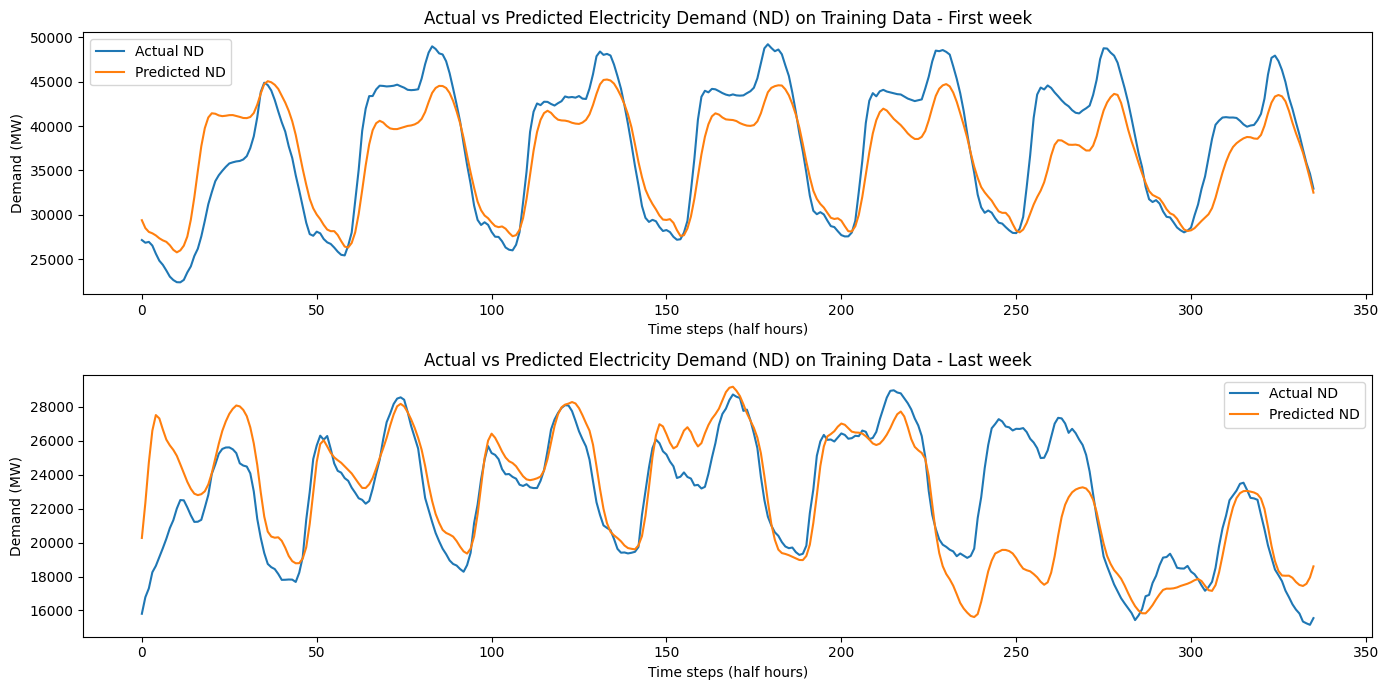

In [137]:
for config_name, result in results.items():
    model = result['trained_model']
    train_loader = result['train_loader']
    y_train = result['y_train']
    scaler = result['scaler']

    print(f'Training predictions for {config_name}')
    train_predictions_inverse, mae_mean, rmse_mean, mae_week_first, rmse_week_first, mae_week_last, rmse_week_last = get_train_predictions(model, train_loader, y_train, scaler)

    result['train_predictions'] = train_predictions_inverse
    result['mae_train_mean'] = mae_mean
    result['rmse_train_mean'] = rmse_mean
    result['mae_train_week_first'] = mae_week_first
    result['rmse_train_week_first'] = rmse_week_first
    result['mae_train_week_last'] = mae_week_last
    result['rmse_train_week_last'] = rmse_week_last


### Manta Ray Feature Optimisation (MRFO)

#### Feature selection

The MRFO feature selction process will be made over the training set, separated into training and validation set, to avoid data leakage during the testing process. Then, the selected features will be trained on the the entire training set, as it was done for the other data sets.

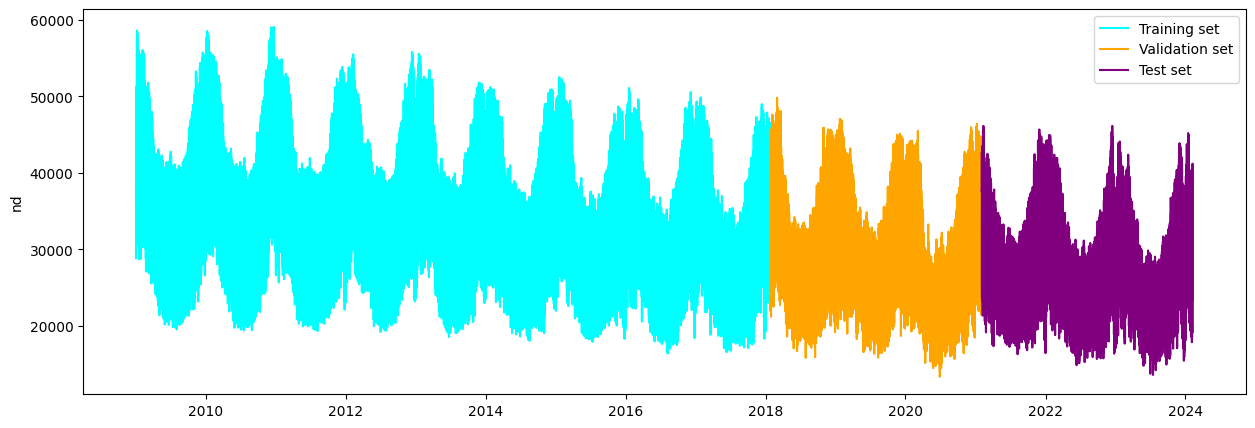

In [138]:
plt.plot(df.index[:int(0.6 * len(df))], df['nd'].iloc[:int(0.6 * len(df))], color='cyan', label='Training set')

plt.plot(df.index[int(0.6 * len(df)):int(0.8 * len(df))], df['nd'].iloc[int(0.6 * len(df)):int(0.8 * len(df))], color='orange', label='Validation set')

plt.plot(df.index[int(0.8 * len(df)):], df['nd'].iloc[int(0.8 * len(df)):], color='purple', label='Test set')

plt.ylabel('nd')
plt.legend()

plt.show()

**Note:**

**The following code ran for 1h30 for a manta rays population of (10, 61) and 10 iterations with 10 epochs each. I have therefore commented it. The results can be found under the filename 'selected_features.pkl'.**

In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = data_all.shape[1] - 1
num_features = data_all.shape[1] - 1
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 10
learning_rate = 0.001
seq_length = 48
batch_size = 336
# criterion = nn.SmoothL1Loss(beta=1.0)
criterion = nn.MSELoss()

best_features = manta_ray_foraging_optimization(data_all, criterion)
save_to_pickle('../selected_features.pkl', best_features)

Epoch 1/10. Loss: 0.01045.
Epoch 2/10. Loss: 0.00257.
Epoch 3/10. Loss: 0.00170.
Epoch 4/10. Loss: 0.00126.
Epoch 5/10. Loss: 0.00102.
Epoch 6/10. Loss: 0.00086.
Epoch 7/10. Loss: 0.00074.
Epoch 8/10. Loss: 0.00066.
Epoch 9/10. Loss: 0.00060.
Epoch 10/10. Loss: 0.00055.
Epoch 1/10. Loss: 0.01158.
Epoch 2/10. Loss: 0.00328.
Epoch 3/10. Loss: 0.00252.
Epoch 4/10. Loss: 0.00226.
Epoch 5/10. Loss: 0.00211.
Epoch 6/10. Loss: 0.00199.
Epoch 7/10. Loss: 0.00186.
Epoch 8/10. Loss: 0.00176.
Epoch 9/10. Loss: 0.00165.
Epoch 10/10. Loss: 0.00152.
Epoch 1/10. Loss: 0.01349.
Epoch 2/10. Loss: 0.00252.
Epoch 3/10. Loss: 0.00170.
Epoch 4/10. Loss: 0.00130.
Epoch 5/10. Loss: 0.00108.
Epoch 6/10. Loss: 0.00088.
Epoch 7/10. Loss: 0.00078.
Epoch 8/10. Loss: 0.00066.
Epoch 9/10. Loss: 0.00060.
Epoch 10/10. Loss: 0.00051.
Epoch 1/10. Loss: 0.00981.
Epoch 2/10. Loss: 0.00346.
Epoch 3/10. Loss: 0.00301.
Epoch 4/10. Loss: 0.00275.
Epoch 5/10. Loss: 0.00263.
Epoch 6/10. Loss: 0.00250.
Epoch 7/10. Loss: 0.00237

#### MFRO - optimised training

In [140]:
file_path2 = os.path.join(current_directory, 'selected_features.pkl')

best_features = load_from_pickle(file_path2)

selected_feature_indices = np.where(best_features == 1)[0]

selected_features = data_all.iloc[:, selected_feature_indices]

data_MRFO = pd.concat([selected_features, data_all['nd']], axis=1)
data_configs["MRFO"] = data_MRFO
data_MRFO

lag_48   lag_96  lag_144  lag_288     nd
settlement_date                                               
2016-01-09 23:30:00  30263.0  28802.0  27571.0  26233.0  27162
2016-01-10 00:00:00  29610.0  28374.0  26931.0  25992.0  26857
2016-01-10 00:30:00  29578.0  28788.0  26972.0  26310.0  26953
2016-01-10 01:00:00  29012.0  28615.0  26576.0  26055.0  26538
2016-01-10 01:30:00  28075.0  27927.0  25788.0  25398.0  25627
...                      ...      ...      ...      ...    ...
2024-02-08 21:30:00  32837.0  30889.0  27882.0  27112.0  30670
2024-02-08 22:00:00  31148.0  29525.0  25701.0  25533.0  28684
2024-02-08 22:30:00  29514.0  28069.0  24124.0  24193.0  27147
2024-02-08 23:00:00  27778.0  26713.0  22357.0  22778.0  25356
2024-02-08 23:30:00  26627.0  26016.0  21369.0  21798.0  24286

[141681 rows x 5 columns]

Epoch 1/10. Loss: 0.01637.
Epoch 2/10. Loss: 0.00575.
Epoch 3/10. Loss: 0.00481.
Epoch 4/10. Loss: 0.00450.
Epoch 5/10. Loss: 0.00429.
Epoch 6/10. Loss: 0.00418.
Epoch 7/10. Loss: 0.00417.
Epoch 8/10. Loss: 0.00406.
Epoch 9/10. Loss: 0.00404.
Epoch 10/10. Loss: 0.00408.
Mean Training MAE over all sequences: 2133.042909793334
Mean Training RMSE over all sequences: 2614.5496717811398


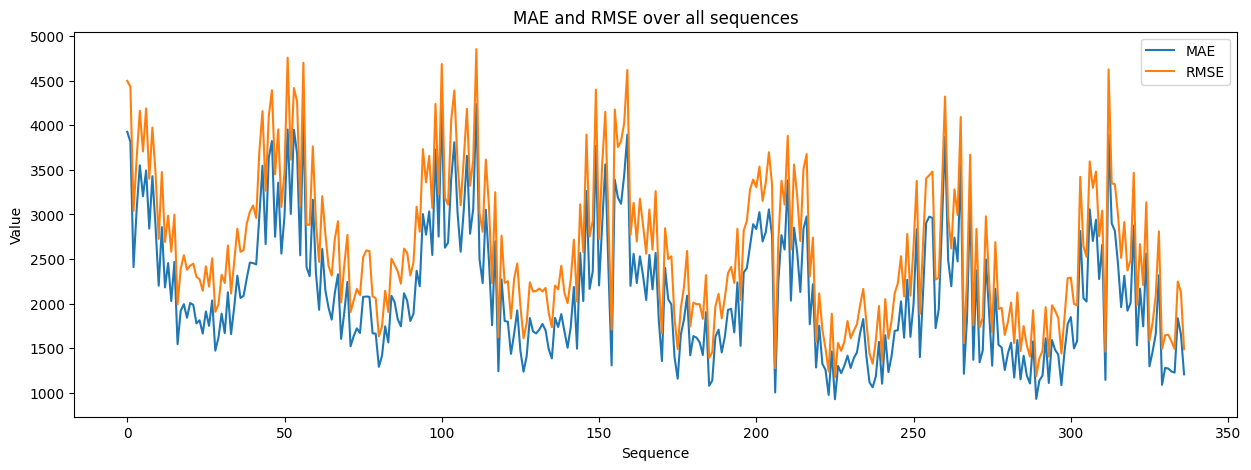

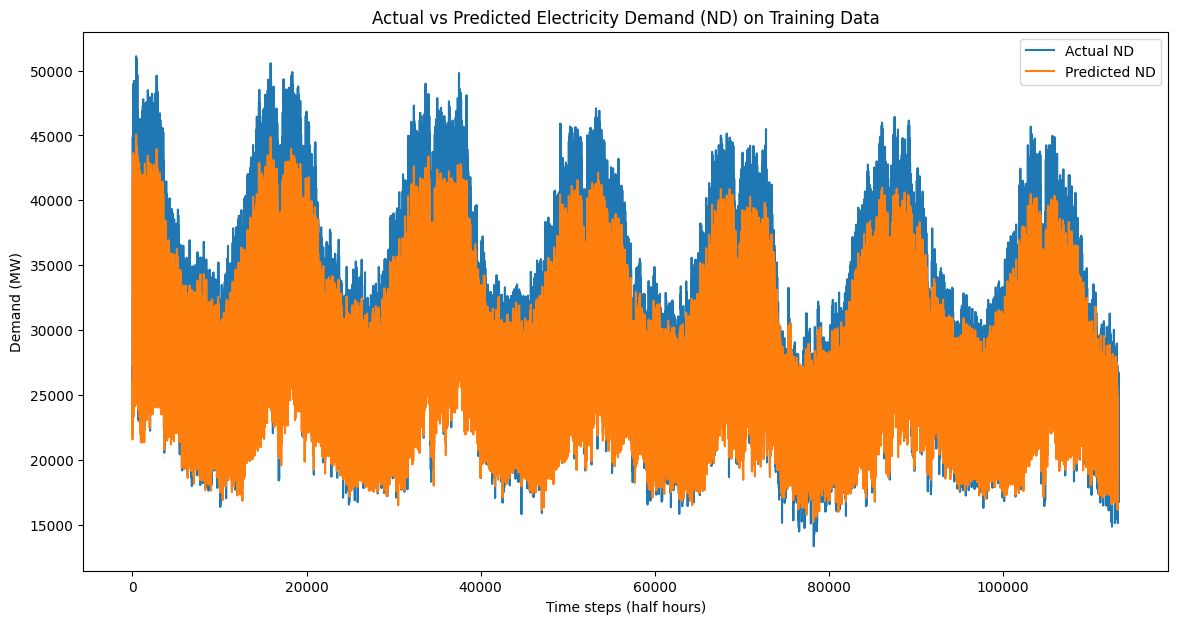

Mean Training MAE and RMSE over first week: 3927.1517740885415, 4498.793222511317
Mean Training MAE and RMSE over last week: 1205.787588936942, 1488.1499411092827


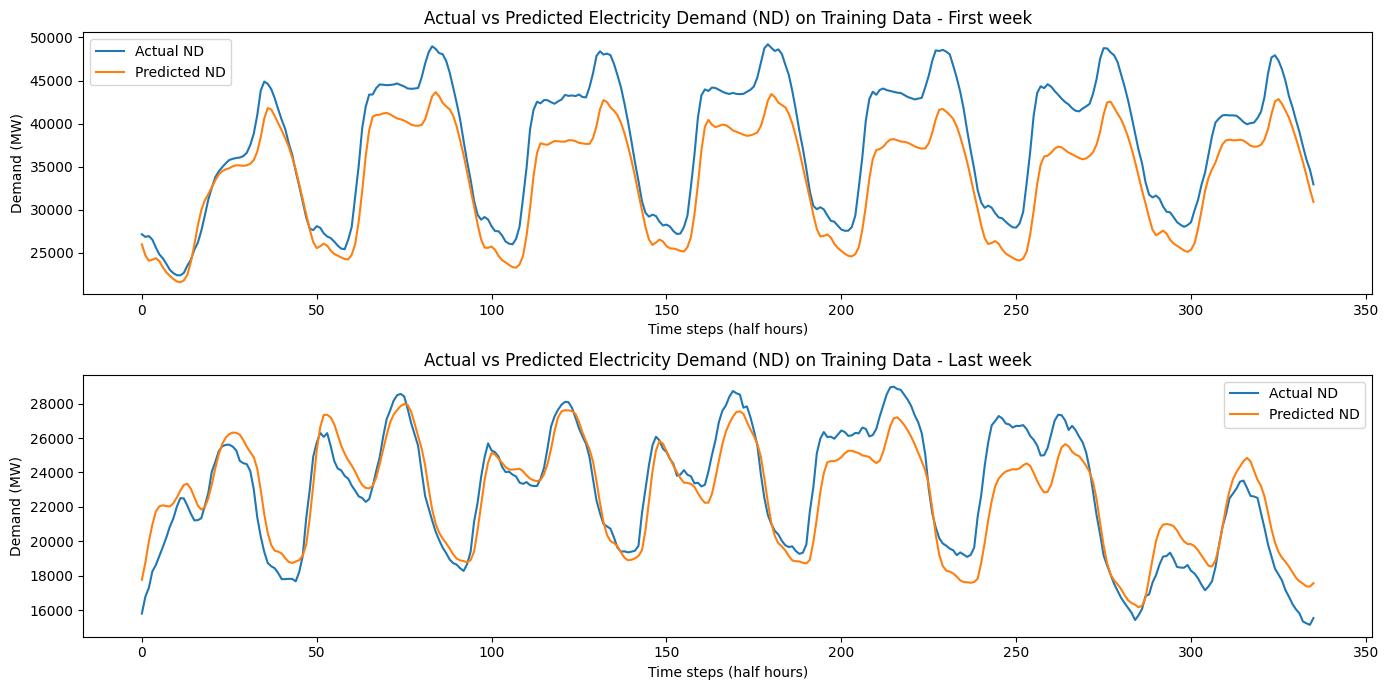

In [141]:
#batch_336, seq_48

for config_name, data in {"MRFO": data_configs["MRFO"]}.items():

    train_loader, test_loader, scaler, X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors, y_train, y_test = create_features_LSTM(
        data, seq_length, batch_size)

    model = LSTM(X_train_tensors.shape[1], hidden_size, num_layers, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    trained_model, loss = train_model(model, train_loader, criterion, optimizer, num_epochs)

    results[config_name] = {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "scaler": scaler,
        "X_train_tensors": X_train_tensors,
        "y_train_tensors": y_train_tensors,
        "X_test_tensors": X_test_tensors,
        "y_test_tensors": y_test_tensors,
        "y_train": y_train,
        "y_test": y_test,
        "loss": loss,
        "trained_model": trained_model
    }

file_path3 = os.path.join(current_directory, 'trained_model_MRFO.pth')

# Get training predictions and evaluation metrics
for config_name, result in {"MRFO": results["MRFO"]}.items():
    model = result['trained_model']
    save_model_complete(model, file_path3, optimizer)
    train_loader = result['train_loader']
    y_train = result['y_train']
    scaler = result['scaler']

    train_predictions_inverse, mae_mean, rmse_mean, mae_week_first, rmse_week_first, mae_week_last, rmse_week_last = get_train_predictions(model, train_loader, y_train, scaler)

    result['train_predictions'] = train_predictions_inverse
    result['mae_train_mean'] = mae_mean
    result['rmse_train_mean'] = rmse_mean
    result['mae_train_week_first'] = mae_week_first
    result['rmse_train_week_first'] = rmse_week_first
    result['mae_train_week_last'] = mae_week_last
    result['rmse_train_week_last'] = rmse_week_last


# FORECASTING

### LSTMs

#### 7-day ahead prediction

Testing predictions for hourly
Mean Absolute Error: 2174.6605269639267, Root Mean Squared Error: 2907.1413809376786


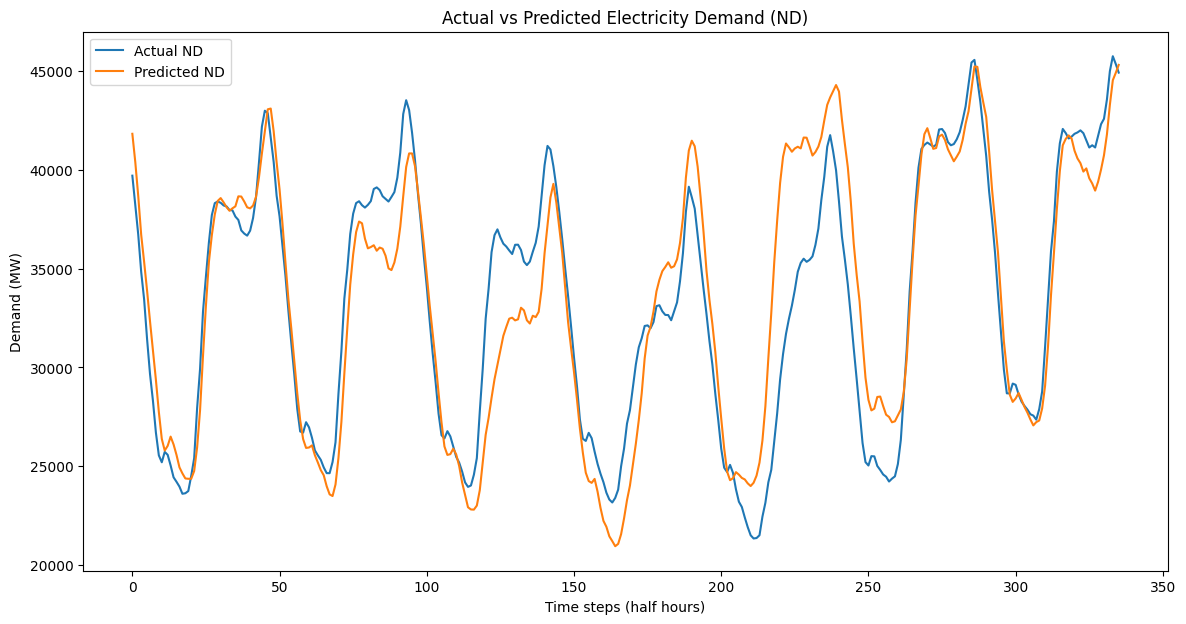

Testing predictions for daily
Mean Absolute Error: 1863.4949801762898, Root Mean Squared Error: 2275.232495641916


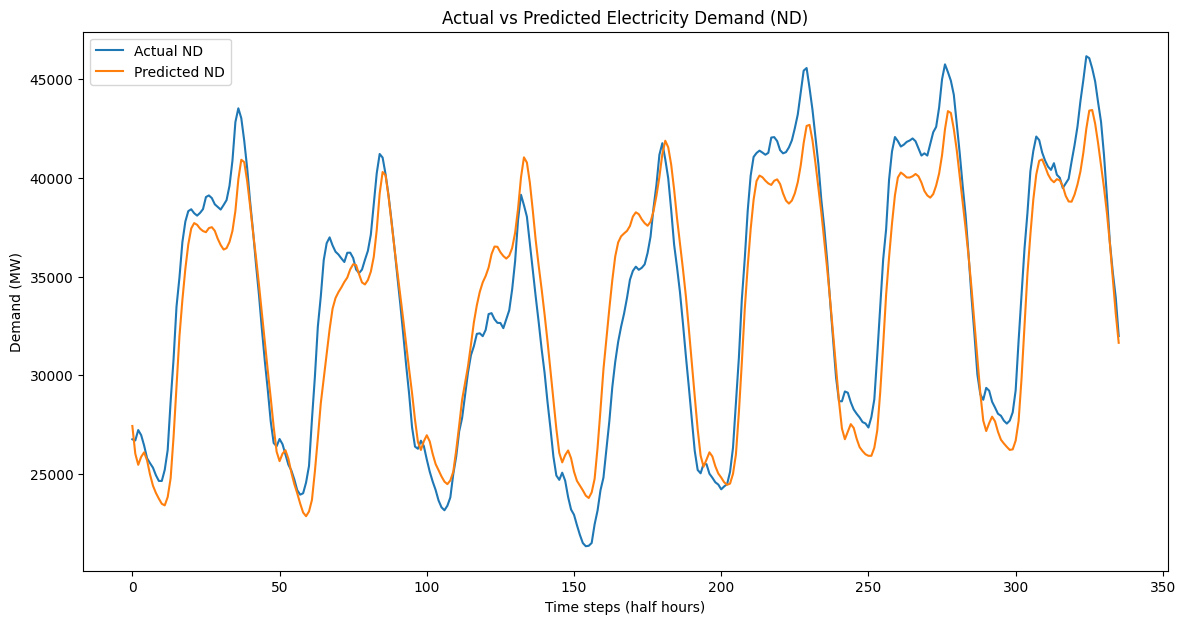

Testing predictions for yearly
Mean Absolute Error: 1492.9622167304735, Root Mean Squared Error: 1967.2665616676795


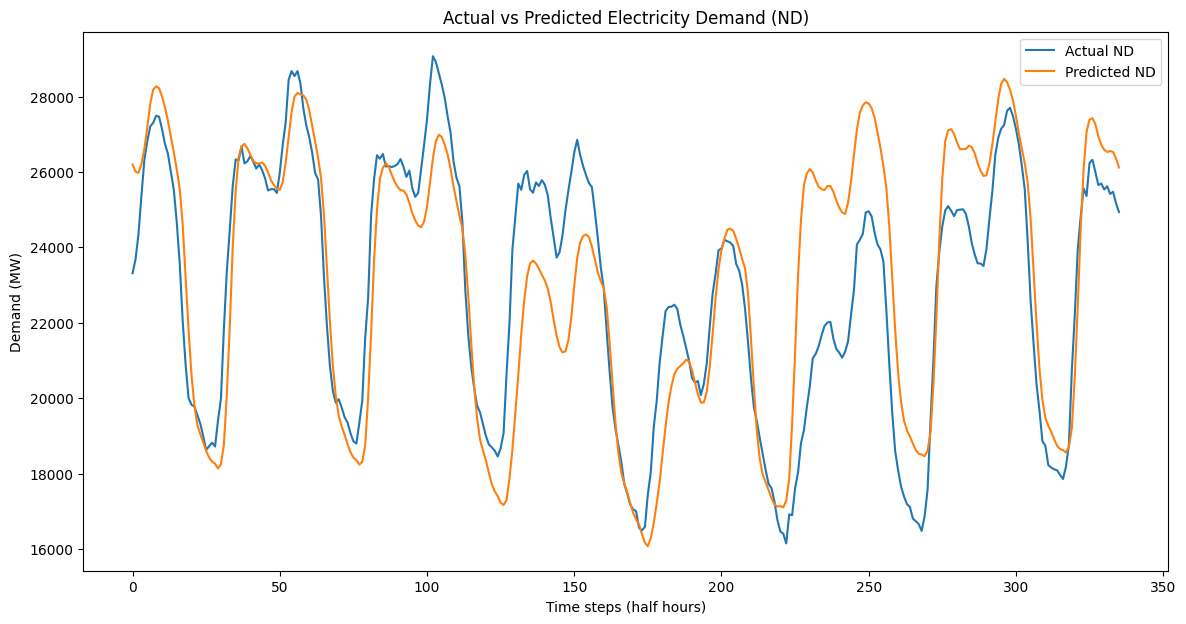

Testing predictions for daily_yearly
Mean Absolute Error: 1408.6525492095388, Root Mean Squared Error: 1785.2241673753147


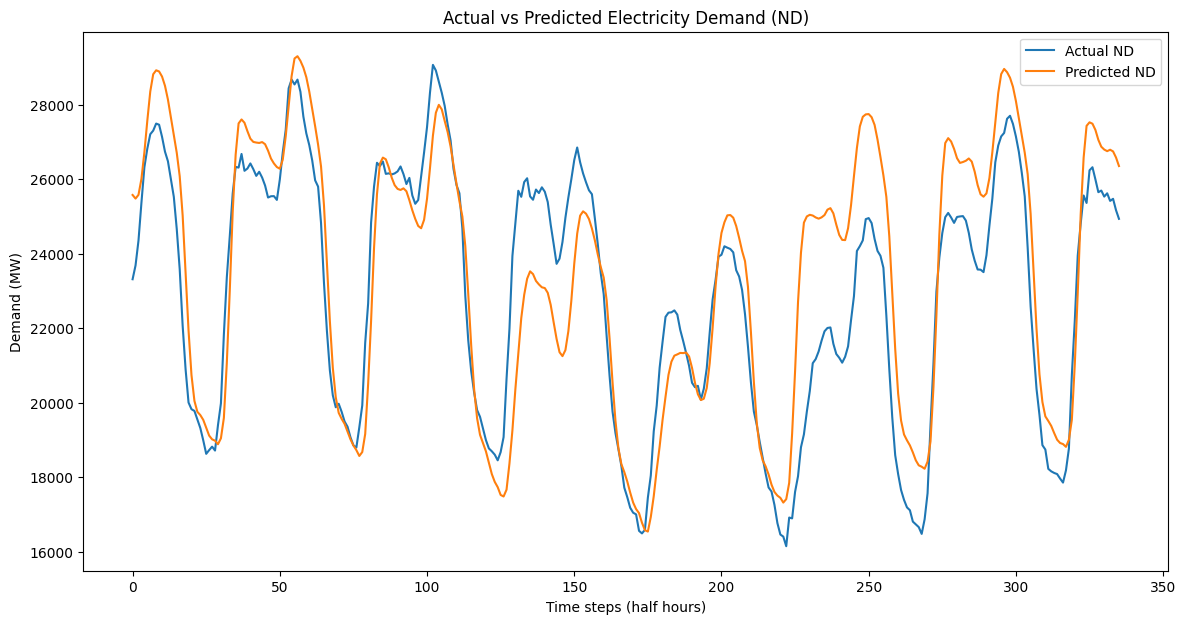

Testing predictions for all
Mean Absolute Error: 1456.656816281334, Root Mean Squared Error: 1933.3398534746516


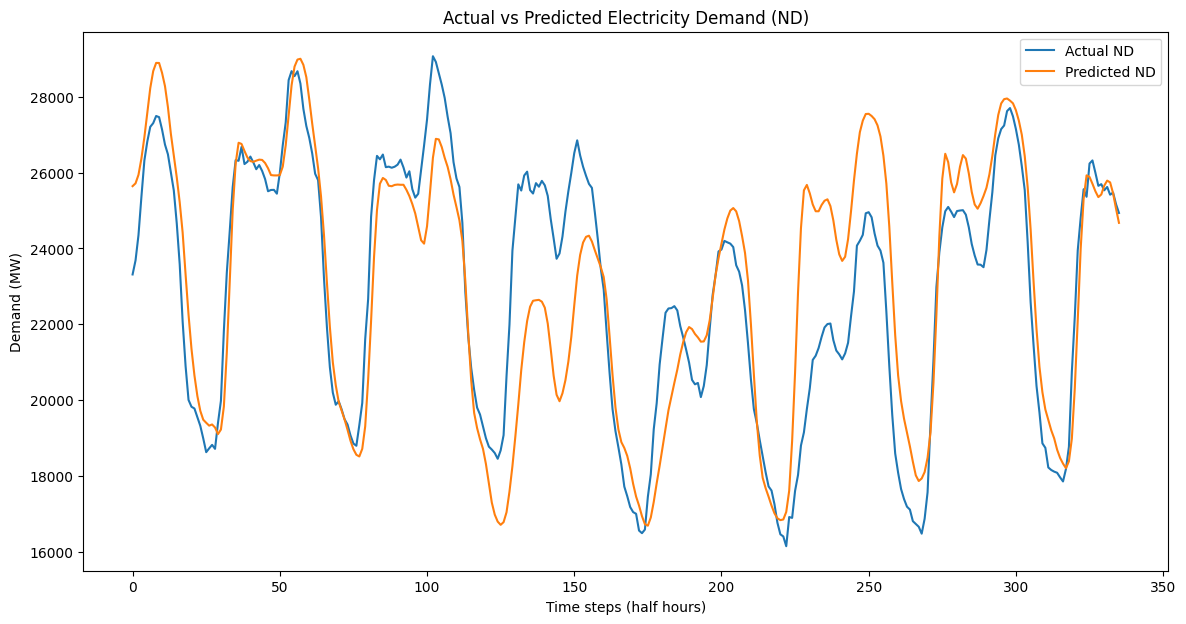

Testing predictions for MRFO
Mean Absolute Error: 1229.765588407316, Root Mean Squared Error: 1663.9893332722204


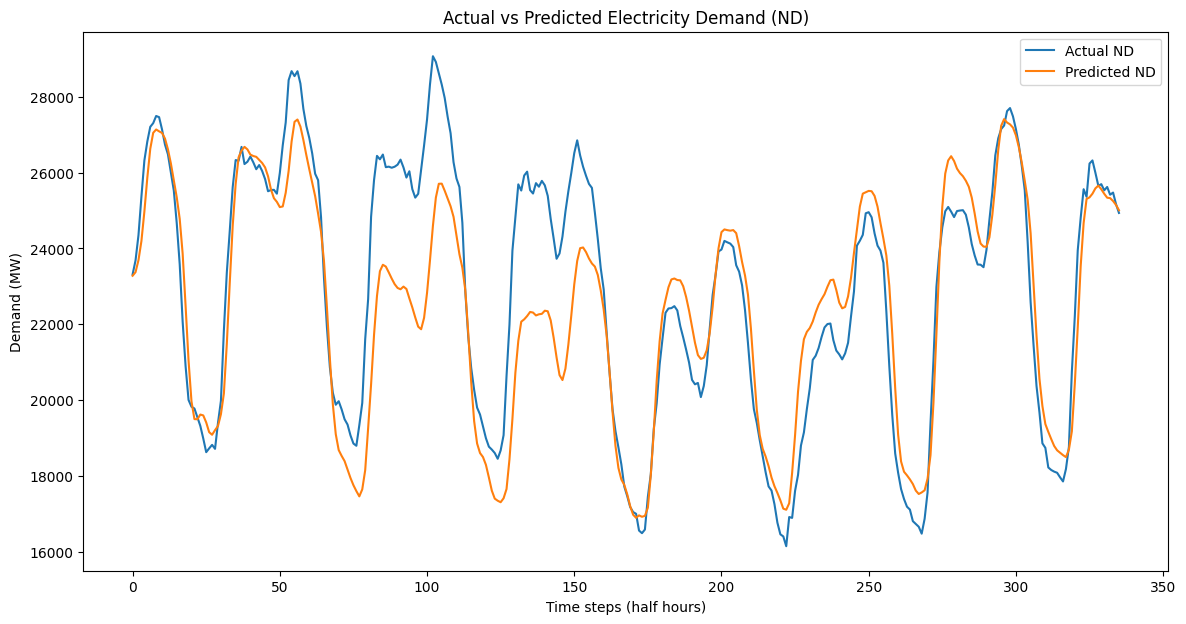

In [142]:
for config_name, result in results.items():
    model = result['trained_model']
    test_loader = result['test_loader']
    y_test = result['y_test']
    scaler = result['scaler']

    print(f'Testing predictions for {config_name}')
    test_predictions_week, mae_test_week, rmse_test_week  = predict_n_steps(model, test_loader, y_test, scaler, n_steps=336)

    result['test_predictions_week'] = test_predictions_week
    result['mae_test_week'] = mae_test_week
    result['rmse_test_week'] = rmse_test_week

#### 1-day ahead predictions

Testing predictions for hourly
Mean Absolute Error: 1185.1081038117409, Root Mean Squared Error: 1427.5805599653738


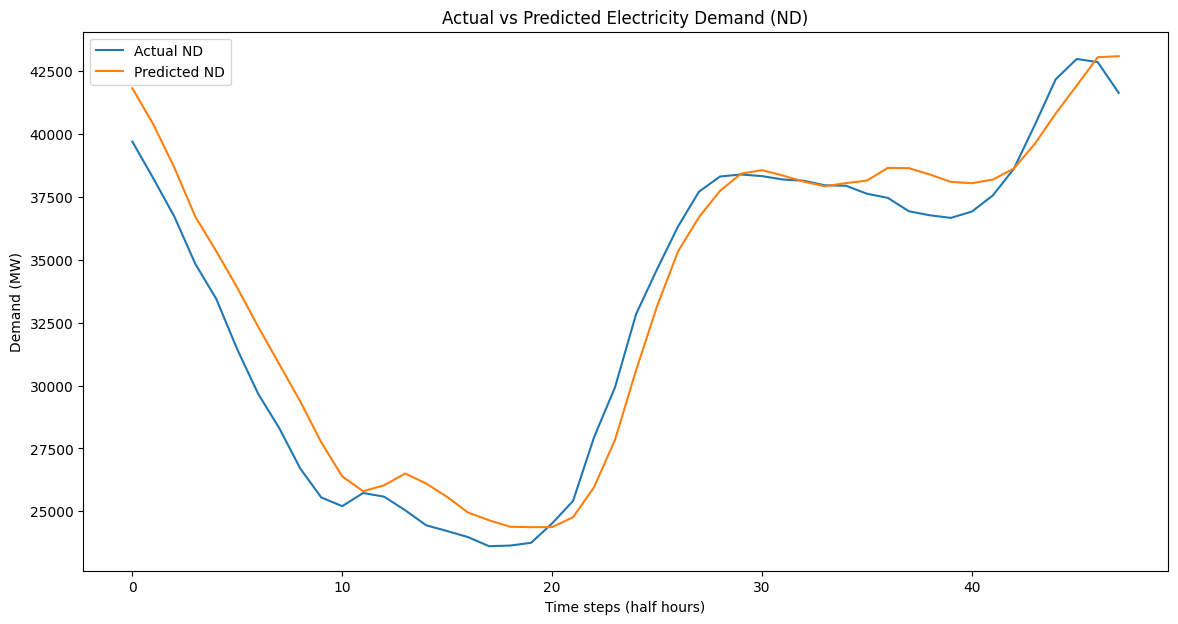

Testing predictions for daily
Mean Absolute Error: 1597.722350160281, Root Mean Squared Error: 1966.3700579901429


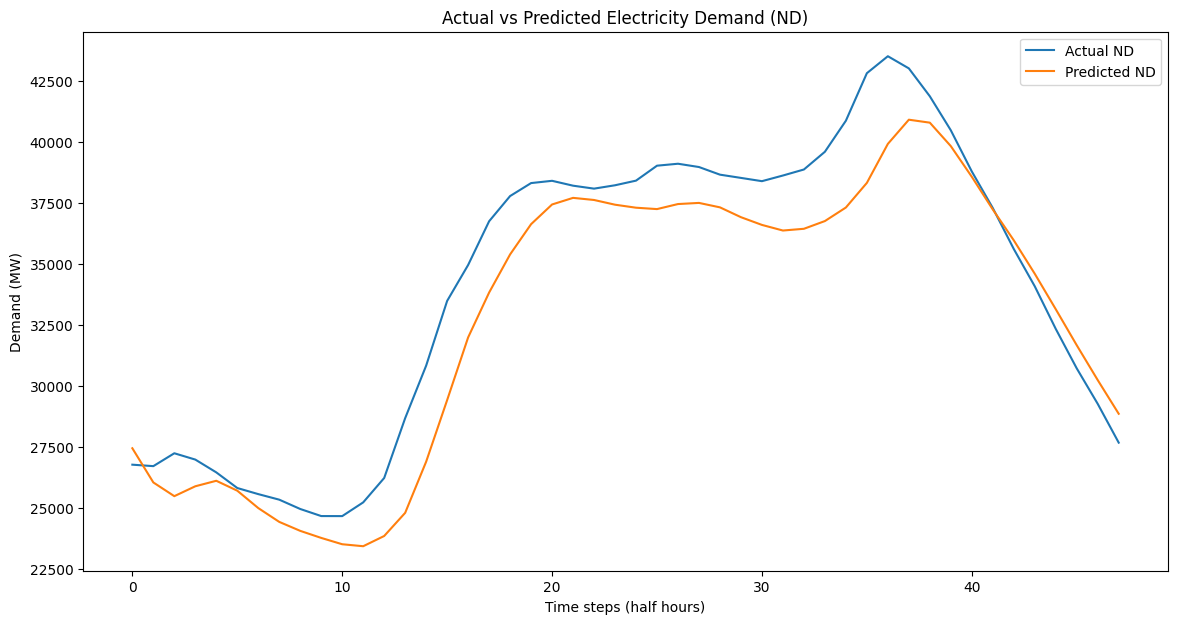

Testing predictions for yearly
Mean Absolute Error: 951.6425097985193, Root Mean Squared Error: 1307.3638480826141


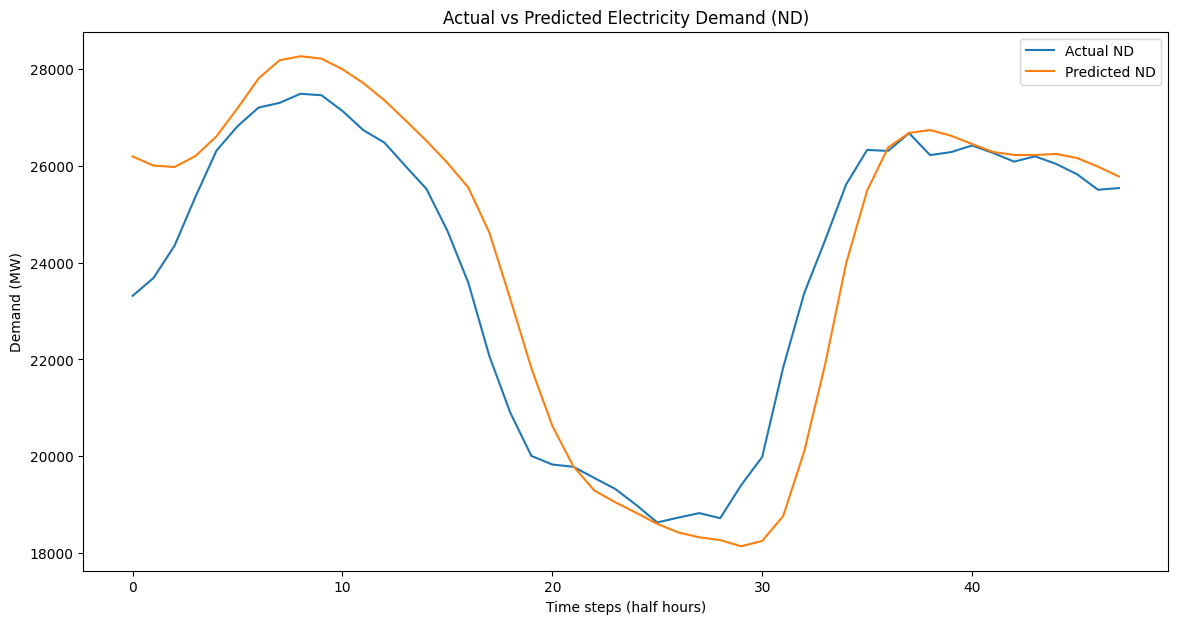

Testing predictions for daily_yearly
Mean Absolute Error: 1186.3124704081565, Root Mean Squared Error: 1373.4687341358256


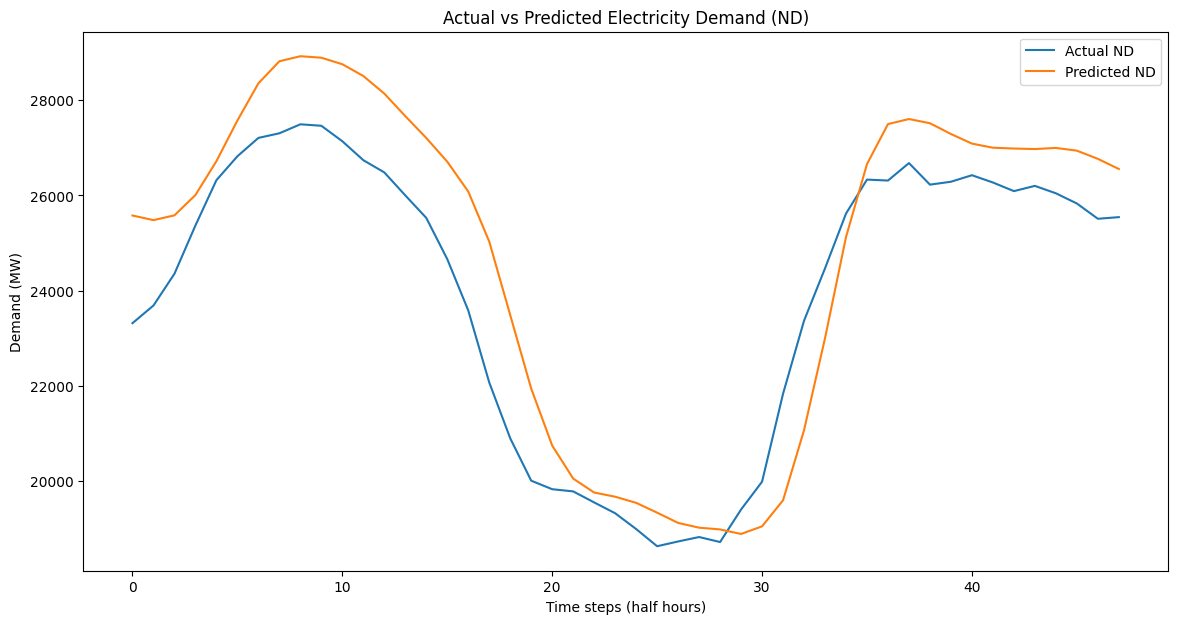

Testing predictions for all
Mean Absolute Error: 965.6988902517284, Root Mean Squared Error: 1184.571747753669


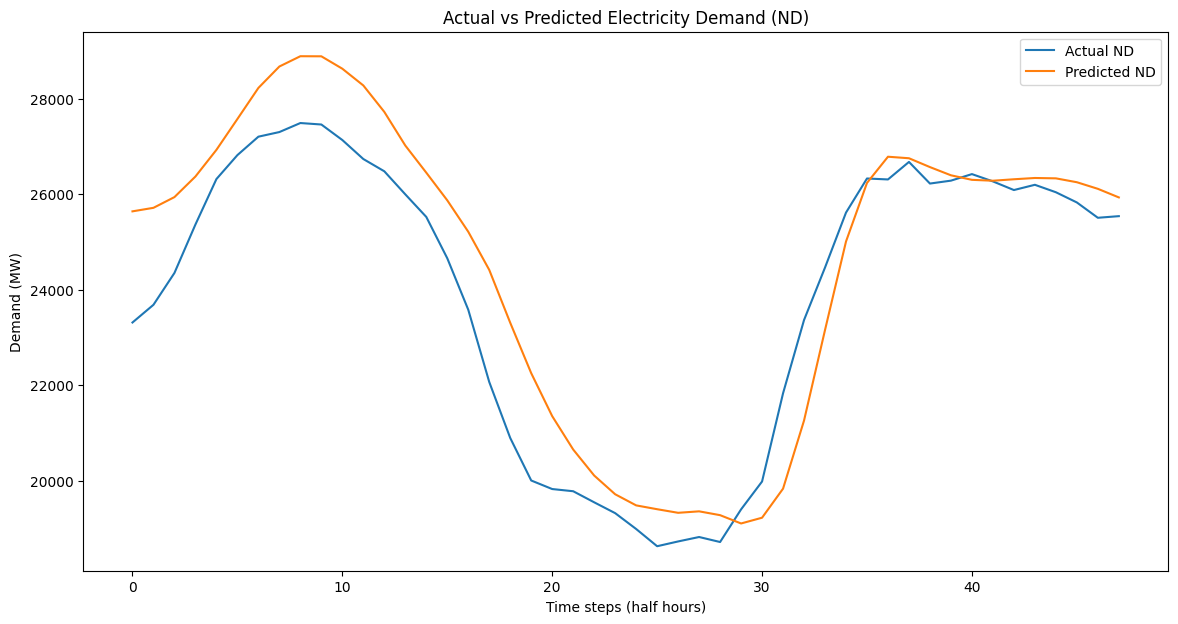

Testing predictions for MRFO
Mean Absolute Error: 545.6019687723989, Root Mean Squared Error: 742.170766400573


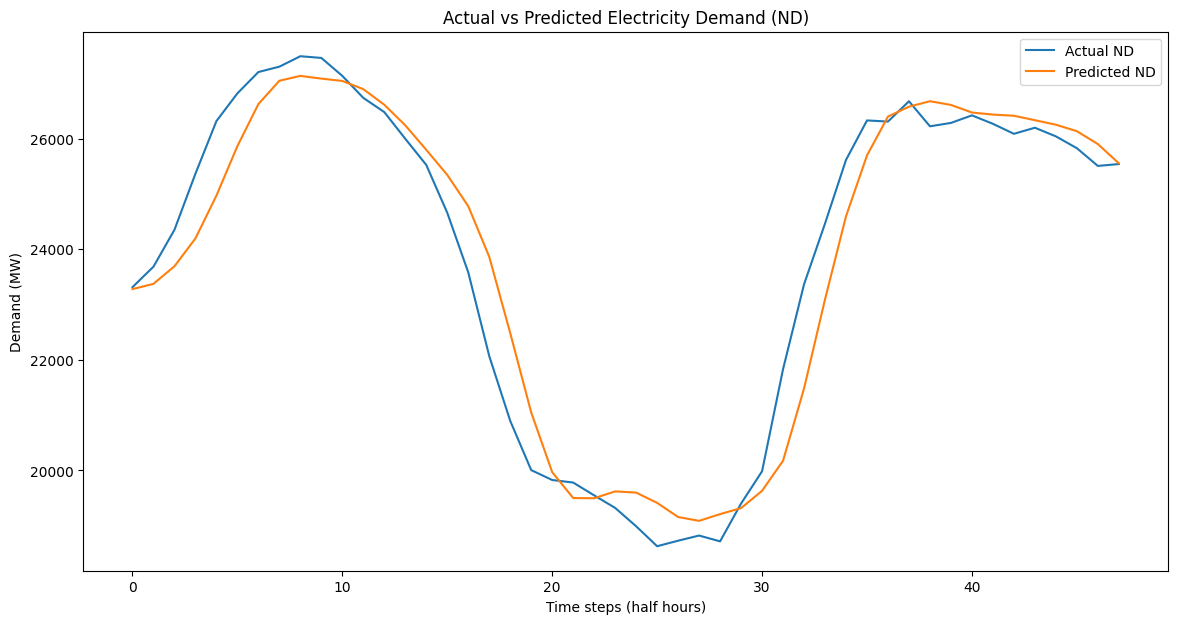

In [143]:
for config_name, result in results.items():
    model = result['trained_model']
    test_loader = result['test_loader']
    y_test = result['y_test']
    scaler = result['scaler']

    print(f'Testing predictions for {config_name}')
    test_predictions_day, mae_test_day, rmse_test_day  = predict_n_steps(model, test_loader, y_test, scaler, n_steps=48)

    result['test_predictions_day'] = test_predictions_day
    result['mae_test_day'] = mae_test_day
    result['rmse_test_day'] = rmse_test_day

### Multiple Linear Regression

RMSE/MAE: (297.53140175023344, 230.80254884481914)


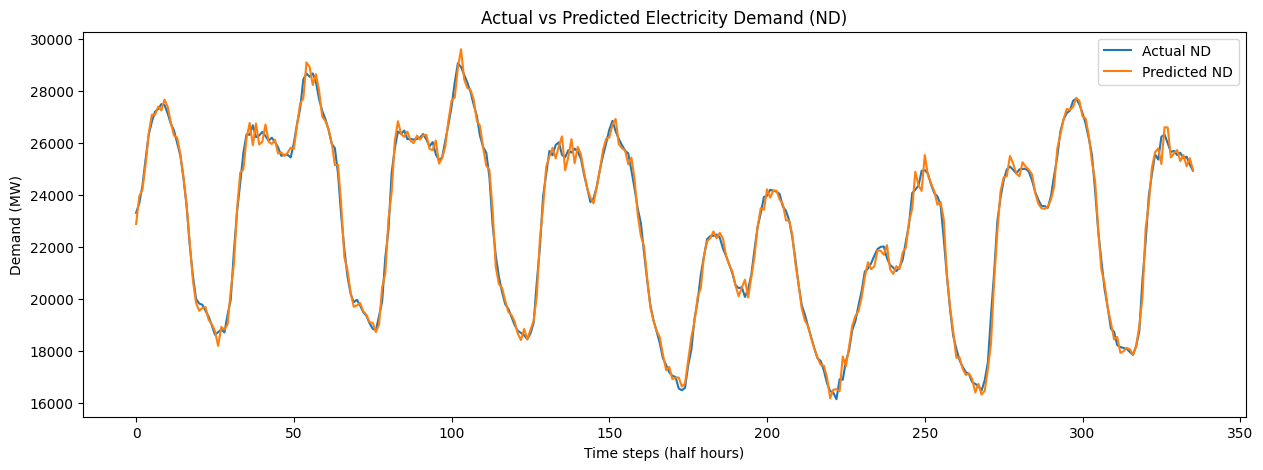

In [144]:
X_mlr = data_all.iloc[:, :-1]
y_mlr = data_all.iloc[:, -1:]

X_train_mlr, X_test_mlr, y_train_mlr, y_test_mlr = train_test_split(X_mlr, y_mlr, test_size=0.2, shuffle = False)

model_mlr = LinearRegression()
model_mlr.fit(X_train_mlr, y_train_mlr)

y_pred_mlr = model_mlr.predict(X_test_mlr)

#7-Day ahead predictions
rmse_mlr = np.sqrt(mean_squared_error(y_test_mlr.to_numpy()[:336], y_pred_mlr[:336]))
mae_mlr  = mean_absolute_error(y_test_mlr.to_numpy()[:336], y_pred_mlr[:336])
print(f'RMSE/MAE: {rmse_mlr, mae_mlr }')

plt.plot(y_test_mlr[:336].to_numpy(), label='Actual ND')
plt.plot(y_pred_mlr[:336], label='Predicted ND')
plt.title('Actual vs Predicted Electricity Demand (ND)')
plt.xlabel('Time steps (half hours)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

RMSE/MAE: (286.9785908686169, 230.78943540359683)


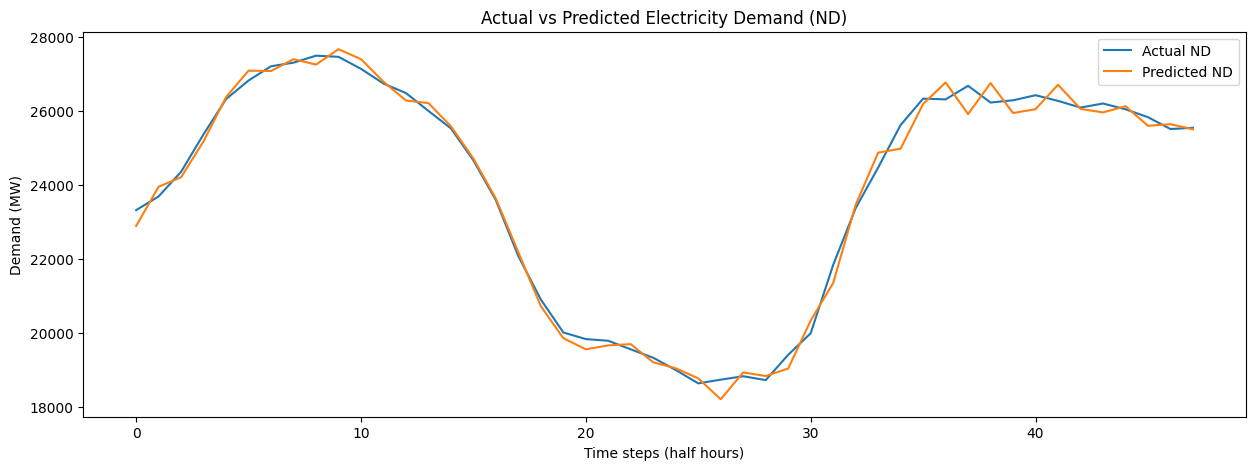

In [145]:
#1-Day aheah predictions

rmse_mlr = np.sqrt(mean_squared_error(y_test_mlr.to_numpy()[:48], y_pred_mlr[:48]))
mae_mlr  = mean_absolute_error(y_test_mlr.to_numpy()[:48], y_pred_mlr[:48])
print(f'RMSE/MAE: {rmse_mlr, mae_mlr }')

plt.plot(y_test_mlr[:48].to_numpy(), label='Actual ND')
plt.plot(y_pred_mlr[:48], label='Predicted ND')
plt.title('Actual vs Predicted Electricity Demand (ND)')
plt.xlabel('Time steps (half hours)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

In [146]:
#Percentage error ranges
p_mlr =[]
p_mlr.append(297.53140175023367*100/(y_test_mlr[:336].min()))
p_mlr.append(297.53140175023367*100/(y_test_mlr[:336].max()))
p_mlr.append(286.97859086861683*100/(y_test_mlr[:48].min()))
p_mlr.append(286.97859086861683*100/(y_test_mlr[:48].max()))
p_mlr

[nd    1.842528
 dtype: float64,
 nd    1.0235
 dtype: float64,
 nd    1.540577
 dtype: float64,
 nd    1.043786
 dtype: float64]

# Summary result tables and plots and Wilcoxon test

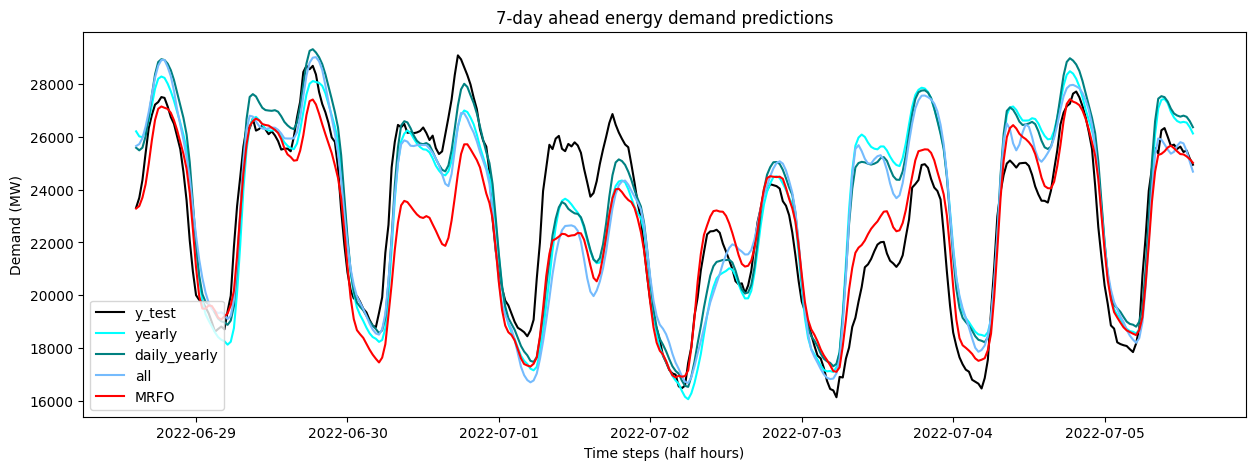

In [147]:
length_subdata = 141681

start_index = len(df)- length_subdata

train_indices = df.index[start_index:start_index+int(length_subdata * 0.8)]
test_indices = df.index[start_index+int(length_subdata * 0.8):start_index+int(length_subdata * 0.8)+336]

#Week-ahead predictions
plt.plot(test_indices, results['yearly']['y_test'][:336], color='black', label='y_test')
plt.plot(test_indices, results['yearly']['test_predictions_week'].flatten(), color='cyan', label='yearly')
plt.plot(test_indices, results['daily_yearly']['test_predictions_week'].flatten(), color='teal', label='daily_yearly')
plt.plot(test_indices, results['all']['test_predictions_week'].flatten(), color='xkcd:sky blue', label='all')
plt.plot(test_indices, results['MRFO']['test_predictions_week'].flatten(), color='red', label='MRFO')
plt.title('7-day ahead energy demand predictions')
plt.xlabel('Time steps (half hours)')
plt.ylabel('Demand (MW)')
plt.legend(loc = 'lower left')
plt.show()

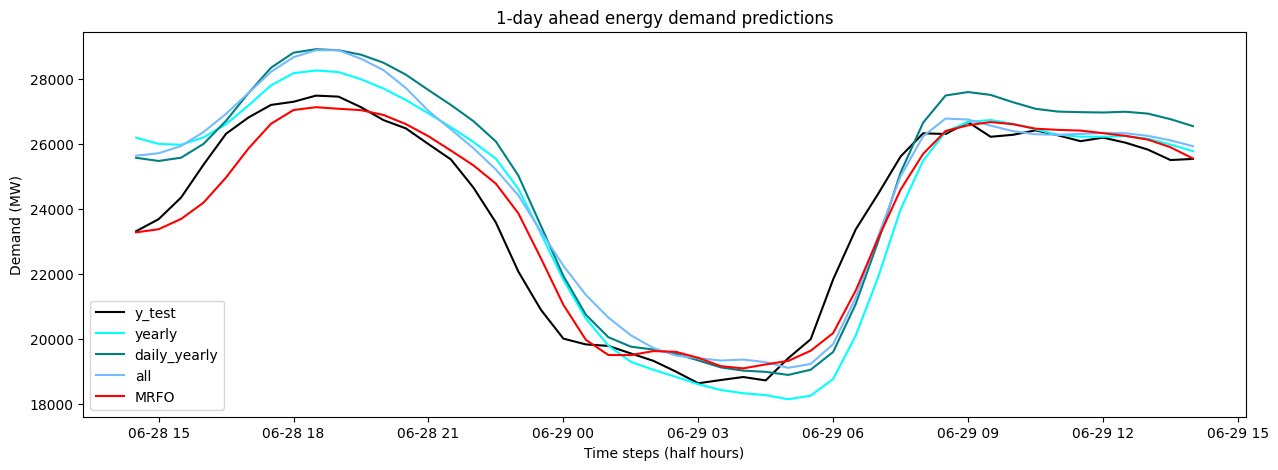

In [148]:
#Day-ahead predictions

plt.plot(test_indices[:48], results['yearly']['y_test'][:48], color='black', label='y_test')
plt.plot(test_indices[:48], results['yearly']['test_predictions_day'].flatten(), color='cyan', label='yearly')
plt.plot(test_indices[:48], results['daily_yearly']['test_predictions_day'].flatten(), color='teal', label='daily_yearly')
plt.plot(test_indices[:48], results['all']['test_predictions_day'].flatten(), color='xkcd:sky blue', label='all')
plt.plot(test_indices[:48], results['MRFO']['test_predictions_day'].flatten(), color='red', label='MRFO')
plt.title('1-day ahead energy demand predictions')
plt.xlabel('Time steps (half hours)')
plt.ylabel('Demand (MW)')
plt.legend(loc = 'lower left')
plt.show()

In [149]:
table_data = {} #shape results
table_data2 = {} #metrics results

for config_name, config_results in results.items():
    table_data[config_name] = {
        "X train shape": config_results["X_train_tensors"].shape,
        "y train shape": config_results["y_train_tensors"].shape,
        "X test shape": config_results["X_test_tensors"].shape,
        "y test shape": config_results["y_test_tensors"].shape,
        "y train shape": config_results["y_train"].shape,
        "y test shape": config_results["y_test"].shape,
        "train predictions shape": config_results["train_predictions"].shape,
        "weekly test predictions shape": config_results["test_predictions_week"].shape,
        "daily test predictions shape": config_results["test_predictions_day"].shape,
    }

for config_name, config_results in results.items():
    table_data2[config_name] = {
        "loss": config_results["loss"][-1],
        "mae_train_mean": config_results["mae_train_mean"],
        "rmse_train_mean": config_results["rmse_train_mean"],
        "mae_train_week_first": config_results["mae_train_week_first"],
        "rmse_train_week_first": config_results["rmse_train_week_first"],
        "mae_train_week_last": config_results["mae_train_week_last"],
        "rmse_train_week_last": config_results["rmse_train_week_last"],
        "mae_test_week": config_results["mae_test_week"],
        "rmse_test_week": config_results["rmse_test_week"],
        "mae_test_day": config_results["mae_test_day"],
        "rmse_test_day": config_results["rmse_test_day"],
    }

shape_results = pd.DataFrame.from_dict(table_data, orient='index')
metrics_results = pd.DataFrame.from_dict(table_data2, orient='index')

In [150]:
metrics_results

loss  mae_train_mean  rmse_train_mean  mae_train_week_first  \
hourly        0.000197     2269.797338      3116.200903           2236.169009   
daily         0.002250     1861.542319      2408.567999           3032.278454   
yearly        0.004663     2849.820839      3558.955952           4367.460339   
daily_yearly  0.003125     1957.111443      2531.447913           2265.717192   
all           0.000469     2309.698007      3022.330558           3094.407796   
MRFO          0.004078     2133.042910      2614.549672           3927.151774   

              rmse_train_week_first  mae_train_week_last  \
hourly                  2985.992463          2273.975830   
daily                   3904.321845          1590.364118   
yearly                  5287.139146          1852.863136   
daily_yearly            2866.966547          1640.194522   
all                     3773.475834          1768.605951   
MRFO                    4498.793223          1205.787589   

              rmse_train_week_last  mae_test_week  rmse_test_week  \
hourly                 2870.105629    2174.660527     2907.141381   
daily                  1943.869633    1863.494980     2275.232496   
yearly                 2423.201288    1492.962217     1967.266562   
daily_yearly           2034.617746    1408.652549     1785.224167   
all                    2704.195965    1456.656816     1933.339853   
MRFO                   1488.149941    1229.765588     1663.989333   

              mae_test_day  rmse_test_day  
hourly         1185.108104    1427.580560  
daily          1597.722350    1966.370058  
yearly          951.642510    1307.363848  
daily_yearly   1186.312470    1373.468734  
all             965.698890    1184.571748  
MRFO            545.601969     742.170766

In [151]:
shape_results

X train shape y train shape X test shape y test shape  \
hourly        (211407, 48)   (211407, 1)  (52852, 48)   (52852, 1)   
daily          (211176, 7)   (211176, 1)   (52795, 7)   (52795, 1)   
yearly         (113344, 7)   (113344, 1)   (28337, 7)   (28337, 1)   
daily_yearly  (113344, 14)   (113344, 1)  (28337, 14)   (28337, 1)   
all           (113344, 61)   (113344, 1)  (28337, 61)   (28337, 1)   
MRFO           (113344, 4)   (113344, 1)   (28337, 4)   (28337, 1)   

             train predictions shape weekly test predictions shape  \
hourly                   (211344, 1)                      (1, 336)   
daily                    (211008, 1)                      (1, 336)   
yearly                   (113232, 1)                      (1, 336)   
daily_yearly             (113232, 1)                      (1, 336)   
all                      (113232, 1)                      (1, 336)   
MRFO                     (113232, 1)                      (1, 336)   

             daily test predictions shape  
hourly                            (1, 48)  
daily                             (1, 48)  
yearly                            (1, 48)  
daily_yearly                      (1, 48)  
all                               (1, 48)  
MRFO                              (1, 48)

In [152]:
#MRFO percentage metrics

percentages= []


percentages.append(1243.026965*100/(y_test_mlr[:336].min()))
percentages.append(1243.026965*100/(y_test_mlr[:336].max()))
percentages.append(1671.804737*100/(y_test_mlr[:336].min()))
percentages.append(1671.804737*100/(y_test_mlr[:336].max()))
percentages.append(570.585912*100/(y_test_mlr[:48].min()))
percentages.append(570.585912*100/(y_test_mlr[:48].max()))
percentages.append(737.577084*100/(y_test_mlr[:48].min()))
percentages.append(737.577084*100/(y_test_mlr[:48].max()))

percentages

[nd    7.697715
 dtype: float64,
 nd    4.275979
 dtype: float64,
 nd    10.353014
 dtype: float64,
 nd    5.750962
 dtype: float64,
 nd    3.063055
 dtype: float64,
 nd    2.075311
 dtype: float64,
 nd    3.959508
 dtype: float64,
 nd    2.682684
 dtype: float64]

(array([ 1.,  2.,  0.,  2.,  0.,  1.,  3.,  7., 12., 11.,  7., 12., 39.,
        34., 48., 26., 34., 27.,  7., 10., 15.,  3., 10.,  6.,  6.,  4.,
         5.,  1.,  0.,  3.]),
 array([-6383.40740439, -5977.22964542, -5571.05188646, -5164.87412749,
        -4758.69636852, -4352.51860955, -3946.34085058, -3540.16309161,
        -3133.98533264, -2727.80757367, -2321.6298147 , -1915.45205574,
        -1509.27429677, -1103.0965378 ,  -696.91877883,  -290.74101986,
          115.43673911,   521.61449808,   927.79225705,  1333.97001602,
         1740.14777498,  2146.32553395,  2552.50329292,  2958.68105189,
         3364.85881086,  3771.03656983,  4177.2143288 ,  4583.39208777,
         4989.56984674,  5395.7476057 ,  5801.92536467]),
 <BarContainer object of 30 artists>)

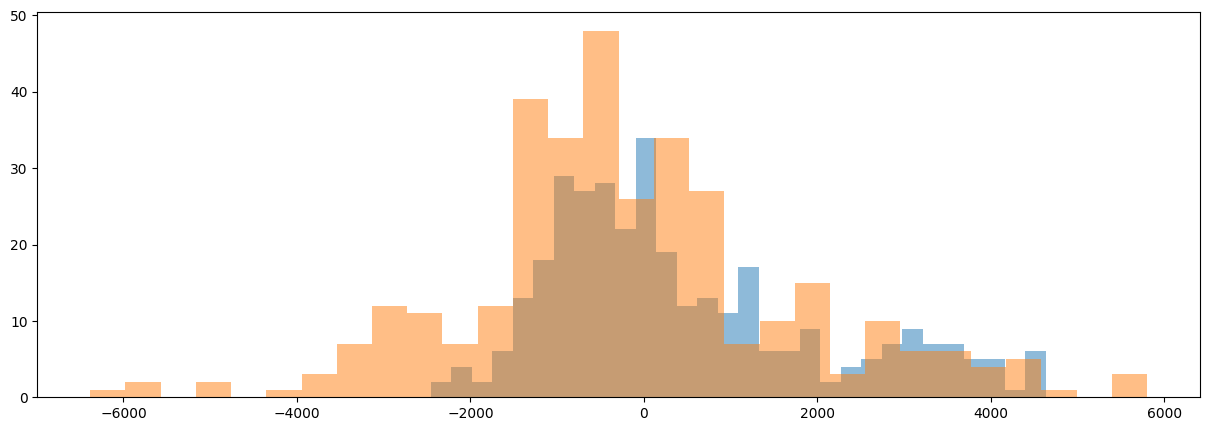

In [153]:
# Calculate residuals (errors) for both models
errors_MRFO = results['MRFO']['y_test'].flatten()[:336] - results['MRFO']['test_predictions_week'].flatten()
errors_baseline = results['all']['y_test'].flatten()[:336] - results['all']['test_predictions_week'].flatten()

# Plot the distribution of residuals
plt.hist(errors_MRFO, bins=30, alpha=0.5, label='MRFO')
plt.hist(errors_baseline, bins=30, alpha=0.5, label='baseline')

In [154]:
#Wilcoxon signed-rank test

stat, p_value = wilcoxon(errors_MRFO, errors_baseline)

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

alpha = 0.05

# Interpretation
if p_value < alpha:
    print("The difference in performance between the MRFO-based LSTM model and the baseline model is statistically significant (Wilcoxon test).")
else:
    print("There is no statistically significant difference in performance between the MRFO-based LSTM model and the baseline model (Wilcoxon test).")


Wilcoxon signed-rank test statistic: 10839.0
P-value: 1.0874118742496578e-22
The difference in performance between the MRFO-based LSTM model and the baseline model is statistically significant (Wilcoxon test).
